# 15. Transformer로 번역기 만들기
## 루브릭
1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.  
   데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축 과정이 지시대로 진행되었다.
2. Transformer 번역기 모델이 정상적으로 구동된다.  
   Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.  
   제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷바침한다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

%config InlineBackend.figure_format = 'retina'

# 폰트 경로 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

# 폰트를 matplotlib의 기본 폰트로 설정
plt.rcParams['font.family'] = font.get_name()

# 폰트 설정 확인
print(mpl.font_manager.findfont(font))

/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf


In [2]:
import os
import pandas as pd

import re
import sentencepiece as spm

import tensorflow as tf
import numpy as np
import random

2024-07-11 20:25:09.571466: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-11 20:25:10.424567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Step 1. 데이터 다운로드 (클라우드 유저용)
[jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1)

In [3]:
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, 'data')

In [4]:
# 데이터 불러오기
file_ko = os.path.join(data_dir, 'korean-english-park.train.ko')
file_en = os.path.join(data_dir, 'korean-english-park.train.en')

print('korean data')
with open(file_ko, 'r') as f:
    for i in range(10):
        line = f.readline().strip()
        print(line)

print('\n' * 2)
print('english data')
with open(file_en, 'r') as f:
    for i in range(10):
        line = f.readline().strip()
        print(line)

korean data
개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
그러나 이것은 또한 책상도 필요로 하지 않는다.
79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
"결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.



english data
Much of personal computing is about "can you top this?"
so a mention a few weeks ago about a rechargeable wireless optical mouse brou

In [5]:
# with open(file_ko, 'r') as f:
#     data_ko = [line.strip() for line in f]

# with open(file_en, 'r') as f:
#     data_en = [line.strip() for line in f]

# df = pd.DataFrame(zip(data_ko, data_en))
# df.columns = ['korean', 'english']
# df.head()

# df.to_csv(
#     os.path.join(data_dir, 'translation_data.csv'),
#     index = False,
#     encoding = 'utf-8-sig'
# )

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'translation_data.csv'))
df.head()

,korean,english
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...


## Step 2. 데이터 정제 및 토큰화
1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거. 데이터의 병렬 쌍이 흐트러지지 않게 주의. 중복을 제거한 데이터를 cleaned_corpus에 저장.

In [7]:
print(df.shape)
cleaned_corpus = df.drop_duplicates()
print(cleaned_corpus.shape)

(94123, 2)
(78941, 2)


2. 정제 함수를 아래 조건을 만족하게 정의
- 모든 입력을 소문자로 변환
- 알파벳, 문장부호, 한글만 남기고 모두 제거
- 문장부호 양 옆에 공백을 추가
- 문장 앞뒤의 불필요한 공백을 제거

In [8]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.,!])", r" \1 ", sentence)
    sentence = re.sub(r'\bthe\b', '', sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅣ가-힣a-zA-Z?.!]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [9]:
kor_corpus = list(cleaned_corpus['korean'].apply(preprocess_sentence))
eng_corpus = list(cleaned_corpus['english'].apply(preprocess_sentence))

In [10]:
# kor_corpus.to_csv('./data/kor_corpus.txt', header = False, index = False, sep = '\t')
# eng_corpus.to_csv('./data/eng_corpus.txt', header = False, index = False, sep = '\t')

3. 한글 말뭉치 kor_corpus와 영문 말뭉치 eng_corpus를 각각 분리한 후, 정제하여 토큰화 진행.  
   토큰화에는 Sentencepiece를 활용. 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의. ko_tokenizer과 en_tokenizer를 얻음.  
   en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 함.  
   [google/sentencepiece](https://github.com/google/sentencepiece)  
- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 함.(기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환
- 특수 토큰의 인덱스를 아래와 동일하게 지정.  
  \<PAD\>: 0 / \<BOS\>: 1 / \<EOS\>: 2 / \<UNK\>: 3

In [11]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size = 20000,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    
    model_prefix = f'{lang}_tokenizer'
    spm.SentencePieceTrainer.train(
        input = corpus,
        model_prefix = model_prefix,
        vocab_size = vocab_size,
        pad_id = pad_id,
        bos_id = bos_id,
        eos_id = eos_id,
        unk_id = unk_id,
        user_defined_symbols = ['<PAD>', '<BOS>', '<EOS>', '<UNK>']
    )

    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{model_prefix}.model')

    return tokenizer

In [12]:
# SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

# kor_corpus_path = './data/kor_corpus.txt'
# eng_corpus_path = './data/eng_corpus.txt'
# ko_tokenizer = generate_tokenizer(kor_corpus_path, SRC_VOCAB_SIZE, "ko")
# en_tokenizer = generate_tokenizer(eng_corpus_path, TGT_VOCAB_SIZE, "en")
# en_tokenizer.set_encode_extra_options("bos:eos")

In [13]:
def load_tokenizer(model_path):
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(model_path)
    return tokenizer

In [14]:
ko_model_path = 'ko_tokenizer.model'
en_model_path = 'en_tokenizer.model'

ko_tokenizer = load_tokenizer(ko_model_path)
en_tokenizer = load_tokenizer(en_model_path)
en_tokenizer.set_encode_extra_options("bos:eos")

True

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus와 tgt_corpus를 각각 구축.  
   텐서 enc_train과 dec_train으로 변환.(모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸림)

In [15]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

max_token_length = 50

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
    ko_tokens = ko_tokenizer.encode_as_ids(kor_corpus[idx])
    en_tokens = en_tokenizer.encode_as_ids(eng_corpus[idx])

    if len(ko_tokens) <= max_token_length and len(en_tokens) <= max_token_length:
        src_corpus.append(ko_tokens)
        tgt_corpus.append(en_tokens)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

# 데이터의 형태 확인
print("enc_train shape:", enc_train.shape)
print("dec_train shape:", dec_train.shape)

  0%|          | 0/78941 [00:00<?, ?it/s]

enc_train shape: (74751, 50)
dec_train shape: (74751, 50)


## Step 3. 모델 설계
Transformer 모델 설계

In [16]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [17]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [18]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):
        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [20]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn

In [21]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [22]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [23]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [24]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

## Step 4. 훈련하기
1. 2 Layer를 가지는 Transformer를 선언. 하이퍼파라미터는 자유롭게 조절

In [25]:
transformer = Transformer(
    n_layers = 2,
    d_model = 512,
    n_heads = 8,
    d_ff = 2048,
    src_vocab_size = ko_tokenizer.vocab_size(),
    tgt_vocab_size = en_tokenizer.vocab_size(),
    pos_len = 200,
    dropout = 0.1,
    shared = True
)

2024-07-11 20:25:25.407190: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20628 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:02:00.0, compute capability: 8.6


2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언.  
   Adam Optimizer를 선언. Optimizer의 파라미터 역시 논문과 동일하게 설정.

In [26]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

3. Loss 함수를 정의  
   Seq2seq 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가. 트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문.

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

4. train_step 함수 정의  
   입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 함.

In [28]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])
    
    gradients = tape.gradient(loss, model.trainable_variables)

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

5. 학습을 진행  
   매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 하이퍼파라미터와 생성된 번역을 제출  
   
예문
- 오바마는 대통령이다.
- 시민들은 도시 속에 산다.
- 커피는 필요 없다.
- 일곱 명의 사망자가 발생했다.

Translations
- obama is the president elect .
- they are in the city .
- they don t need to be a lot of drink .
- seven other people have been killed in the attacks .

Hyperparameters
> n_layers: 2  
> d_model: 512  
> n_heads: 8  
> d_ff: 2048  
> dropout: 0.3  

Training Parameters
> Warmup Steps: 4000  
> Batch Size: 64  
> Epoch At: 5  

In [29]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        ax.set_xticklabels(ax.get_xticklabels(), fontproperties=font)
        ax.set_yticklabels(ax.get_yticklabels(), fontproperties=font)

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()

    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [30]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [31]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

translation() 함수의 plot_attention 변수를 True로 주면 번역 결과에 대한 Attention Map을 시각화할 수 있음.  
학습의 전 과정을 구현한 코드. 구현 과정에 참고.

In [32]:
# 학습
from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/tmp/ipykernel_1568227/3456734185.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  t = tqdm_notebook(idx_list)


  0%|          | 0/1168 [00:00<?, ?it/s]

2024-07-11 20:25:34.292252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-07-11 20:25:34.385091: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7963de422760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-11 20:25:34.385137: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2024-07-11 20:25:34.394765: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-11 20:25:34.421045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-07-11 20:25:34.605045: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.

Input: 오바마는 대통령이다.
Predicted translation: obama is a lot of obama s presidential candidate .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is a lot of a lot of .
Input: 커피는 필요 없다.
Predicted translation: it is not to be a lot of .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two days of deadly killed people .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a former president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are a huge city of city s city .
Input: 커피는 필요 없다.
Predicted translation: they do not need to be a matter .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: two deaths death toll killed people .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: it is a bit of city .
Input: 커피는 필요 없다.
Predicted translation: no no no no . or .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: on sunday people died in a .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a moment .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in cities .
Input: 커피는 필요 없다.
Predicted translation: coffee is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died sunday .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a spokesman for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens were in city .
Input: 커피는 필요 없다.
Predicted translation: there need for a safer response to peterson .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven people .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key .
Input: 시민들은 도시 속에 산다.
Predicted translation: men are in downtown .
Input: 커피는 필요 없다.
Predicted translation: it is needed to be prepared to do .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were dead .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a key .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just want to buy a mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee s wooded coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and a personnel official said .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a slight idar .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re only a impose .
Input: 커피는 필요 없다.
Predicted translation: there s no need to take on health .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a material .
Input: 시민들은 도시 속에 산다.
Predicted translation: they say city s green mountain city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported killed .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is ain .
Input: 시민들은 도시 속에 산다.
Predicted translation: black is gone in .
Input: 커피는 필요 없다.
Predicted translation: there needs to tackle exist .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were hit seven .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a material .
Input: 시민들은 도시 속에 산다.
Predicted translation: black head is in city for city .
Input: 커피는 필요 없다.
Predicted translation: there s a need to mentioni .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were hit simultaneously in seven days .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a material .
Input: 시민들은 도시 속에 산다.
Predicted translation: city is december in darkest cities city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for approval .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were confirmed dead .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is second for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: men latest in a row .
Input: 커피는 필요 없다.
Predicted translation: there is no need for fas .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: up to people died sunday while seven people were killed .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a slight tie . obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re in darkest city .
Input: 커피는 필요 없다.
Predicted translation: it needs to move against aircraft .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were injured .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is second barr .
Input: 시민들은 도시 속에 산다.
Predicted translation: they wore in a small city .
Input: 커피는 필요 없다.
Predicted translation: there s no need for nger .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were killed .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a material .
Input: 시민들은 도시 속에 산다.
Predicted translation: they gone in . a half dozen cities
Input: 커피는 필요 없다.
Predicted translation: there needs to need to need h .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died sunday .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is seen by president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they become law in cities you won t buy .
Input: 커피는 필요 없다.
Predicted translation: there needs toself here there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have been killed .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is aside from president .
Input: 시민들은 도시 속에 산다.
Predicted translation: black producers hang on city .
Input: 커피는 필요 없다.
Predicted translation: there is no need fori nor need to be a dose of light .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people died sunday .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a place to whom he is .
Input: 시민들은 도시 속에 산다.
Predicted translation: they wore on city .
Input: 커피는 필요 없다.
Predicted translation: car
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed seven people dead .


  0%|          | 0/1168 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they republican symbolsi make up packages of cities .
Input: 커피는 필요 없다.
Predicted translation: there need for coffee
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed sunday .


Input: 오바마는 대통령이다.
Predicted translation: obama is a for president .
Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_s

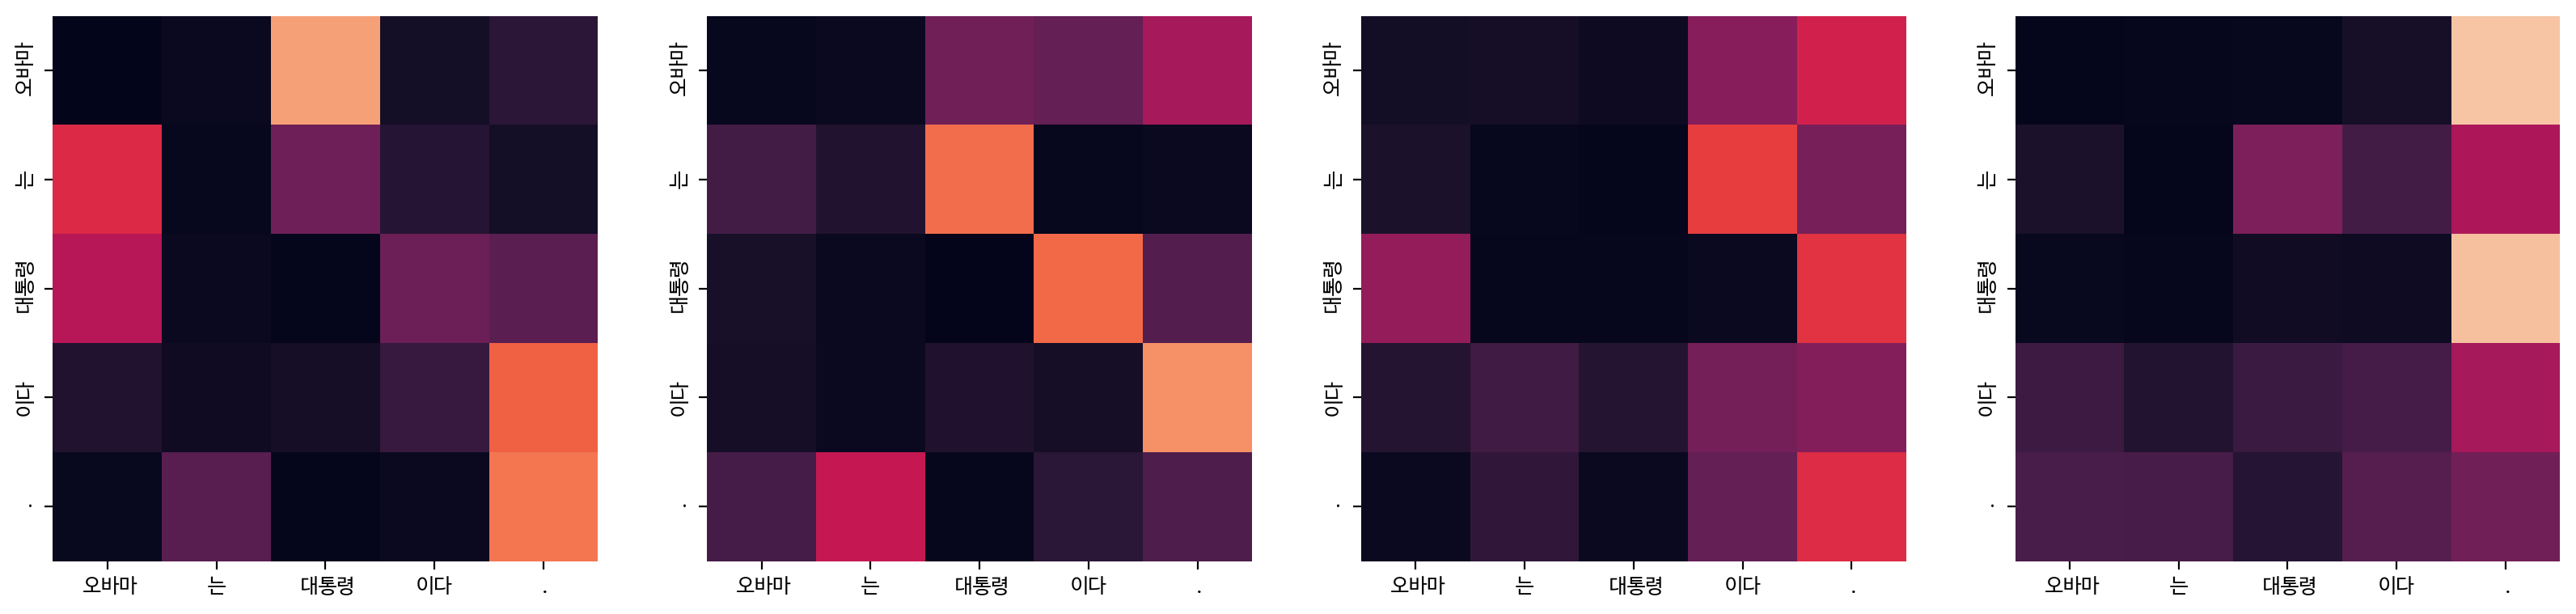

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_s

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Fon

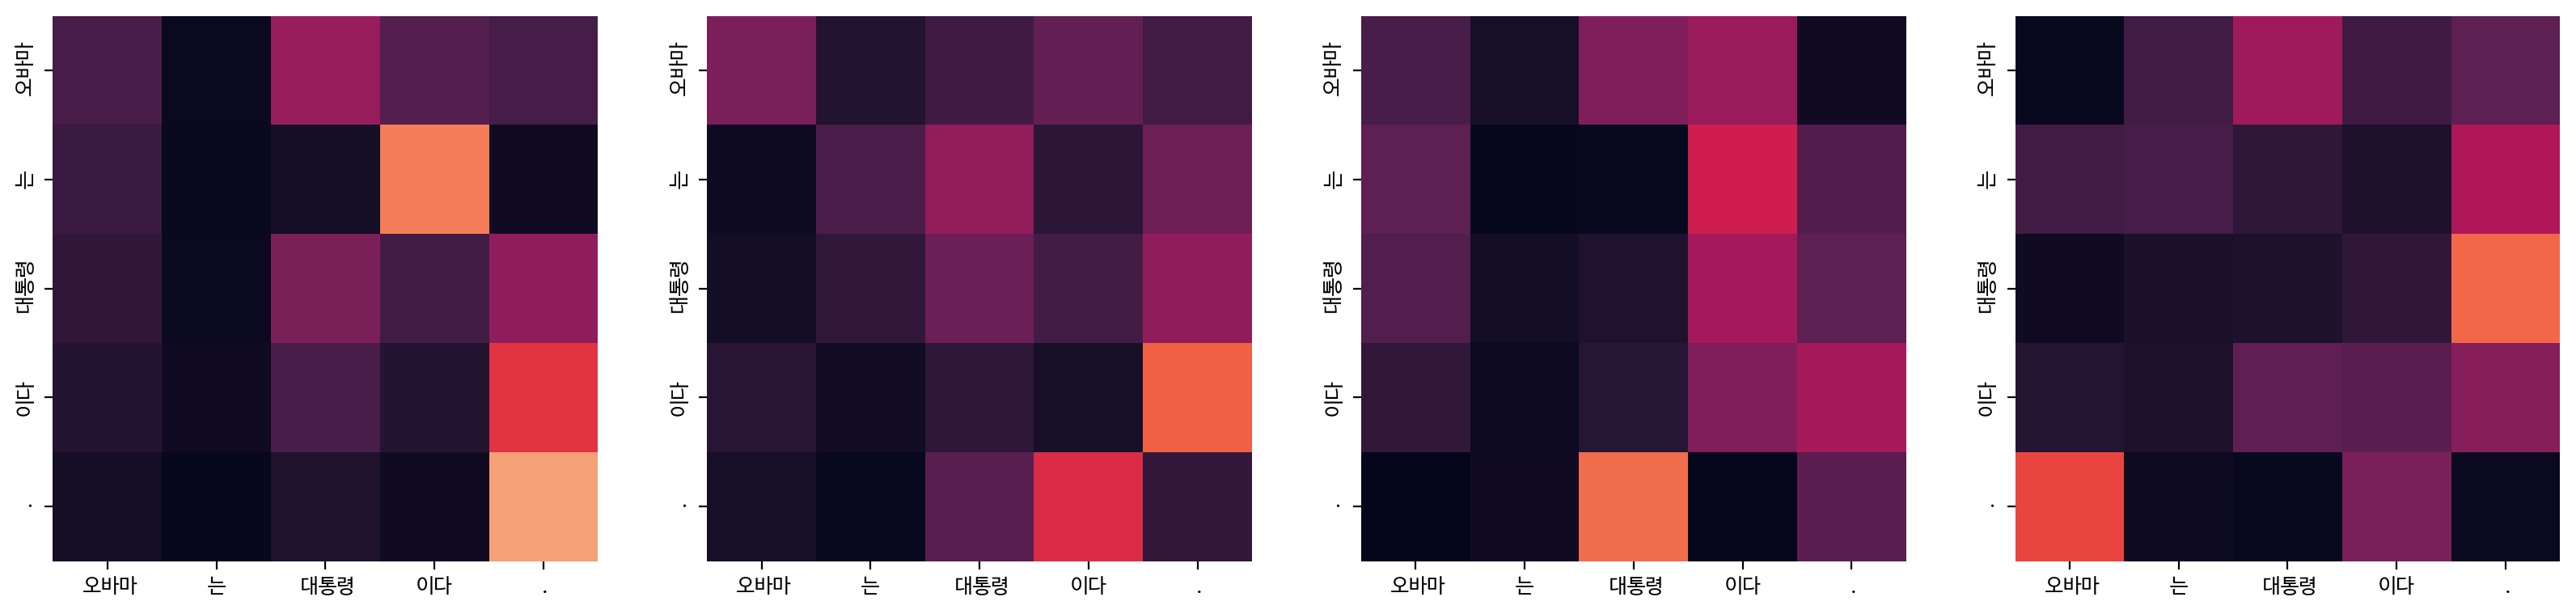

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

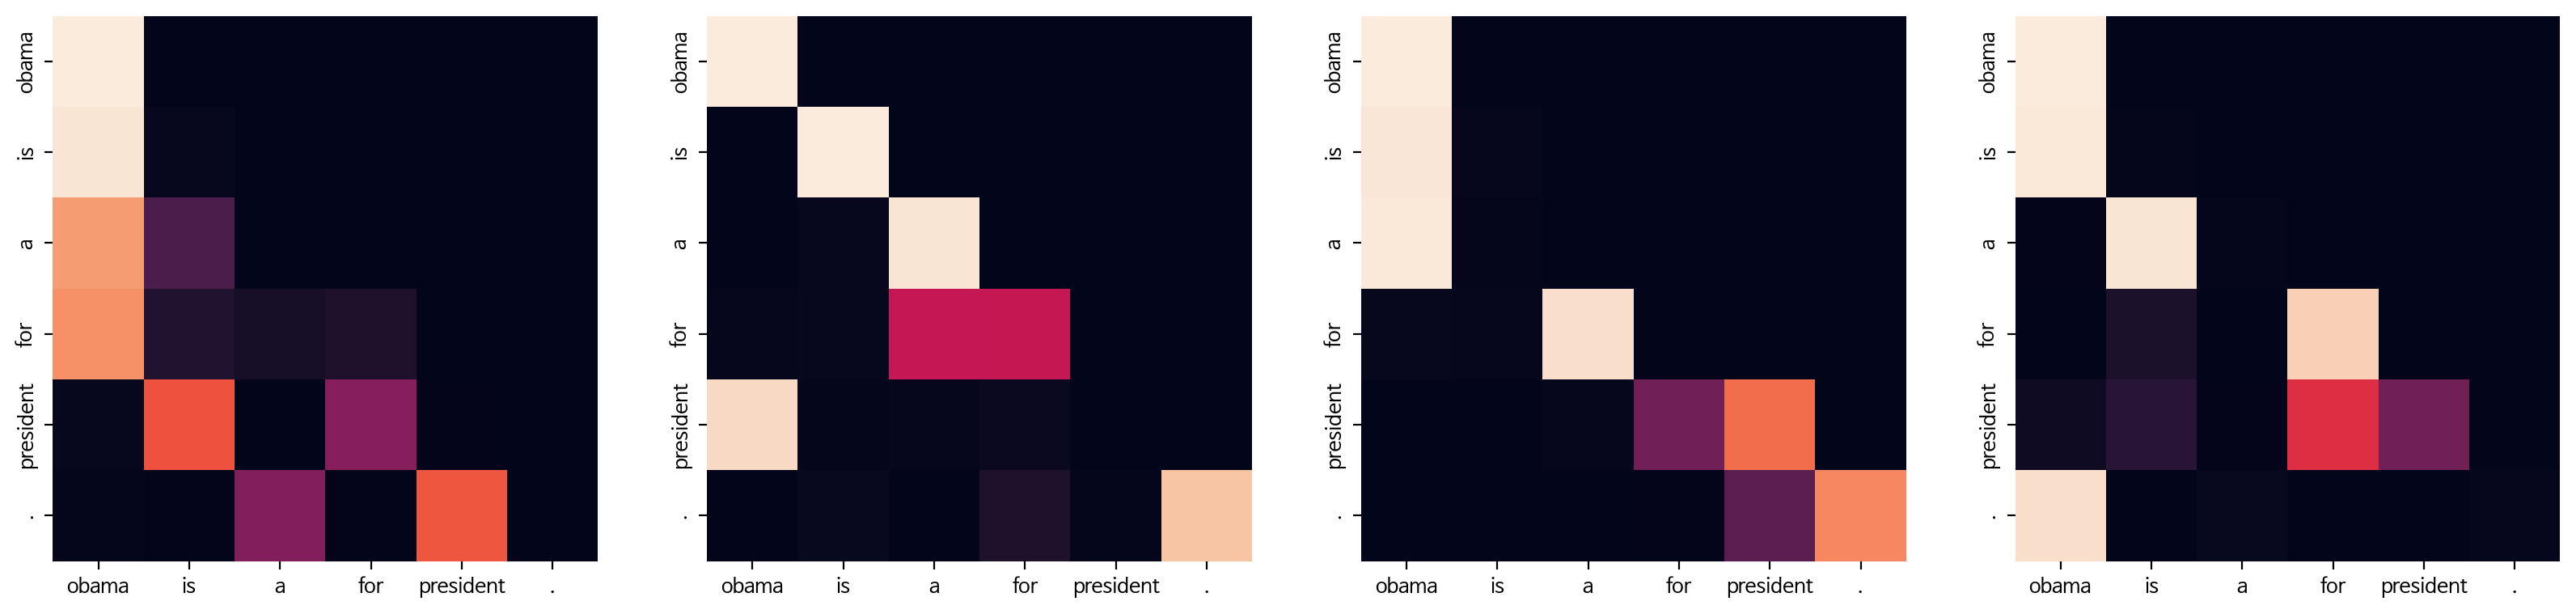

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_s

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61

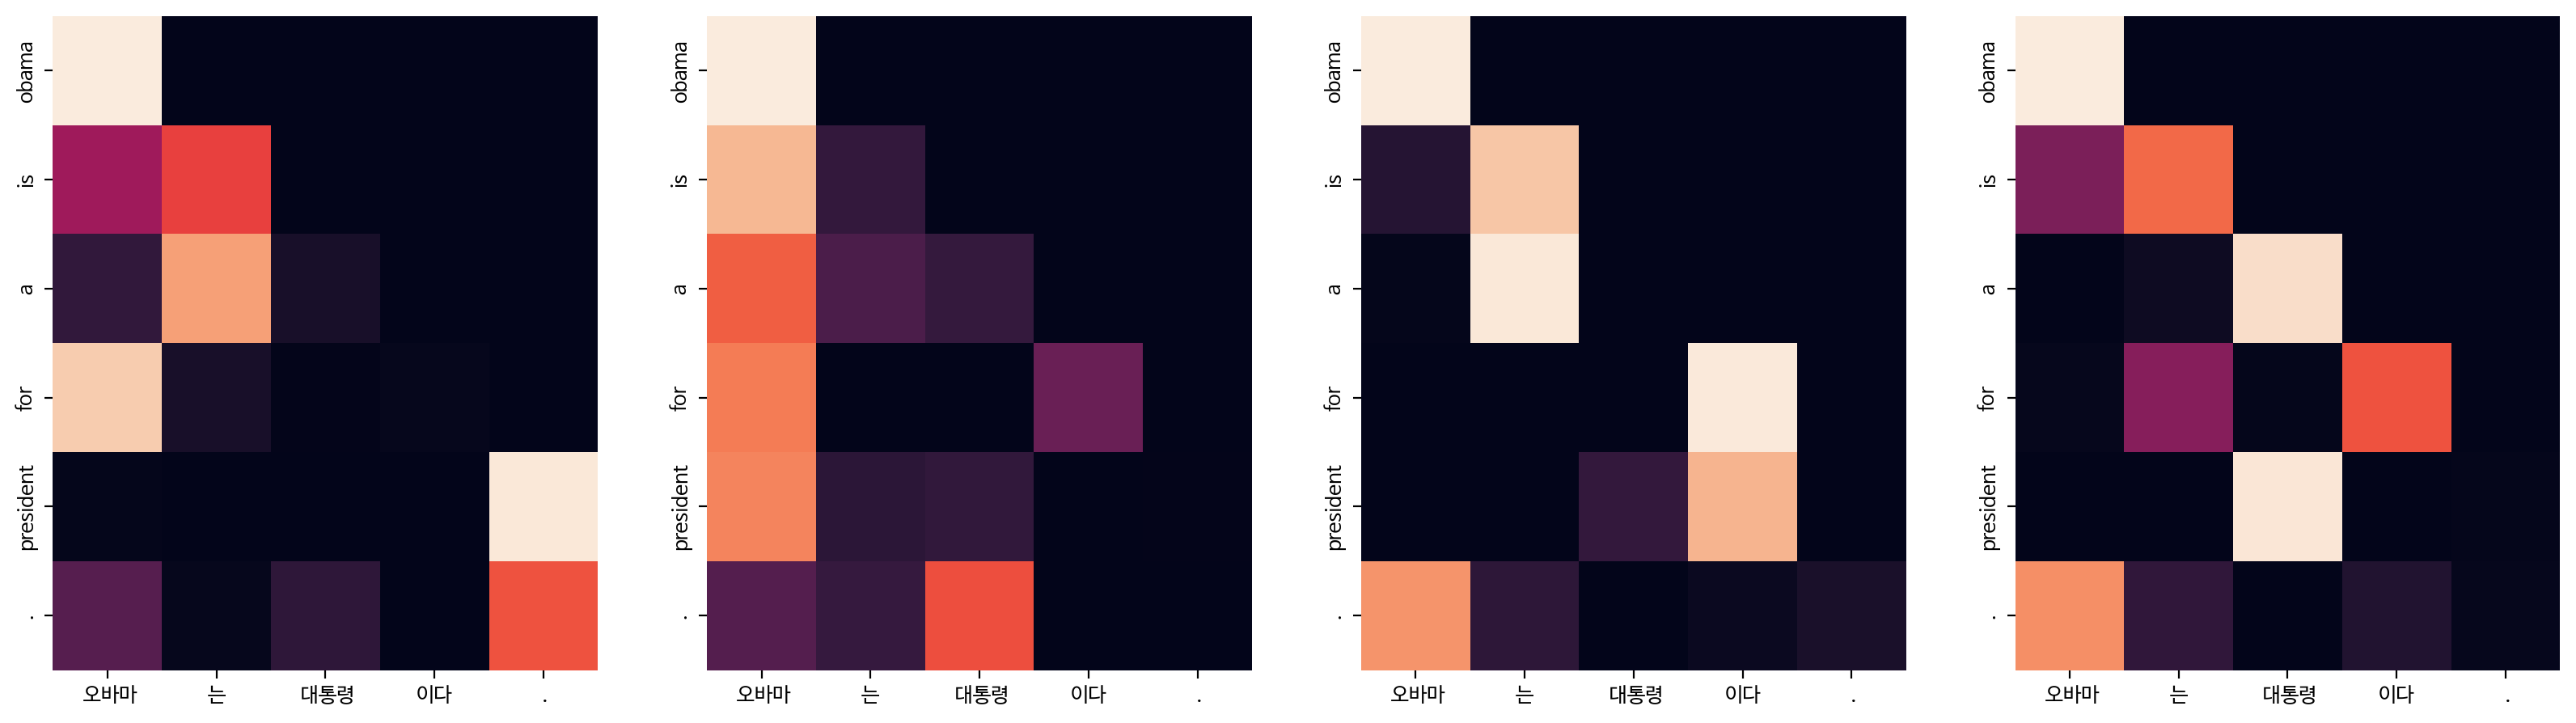

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

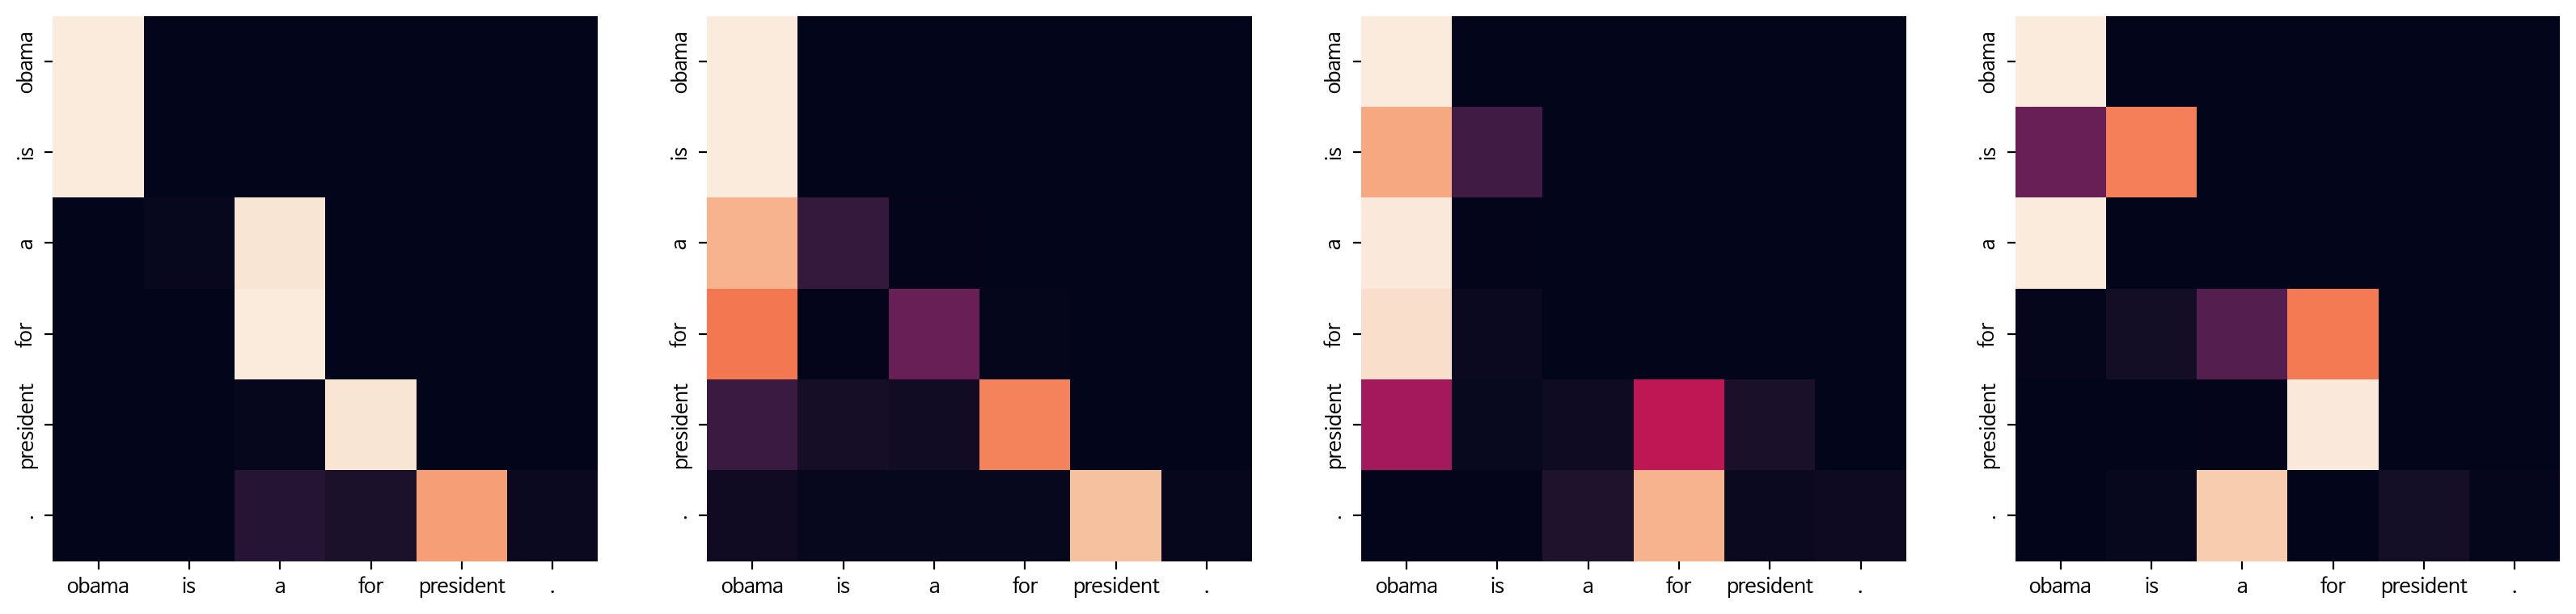

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_s

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 50724 (\N{HANGUL SYLLABLE O}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48148 (\N{HANGUL SYLLABLE BA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3

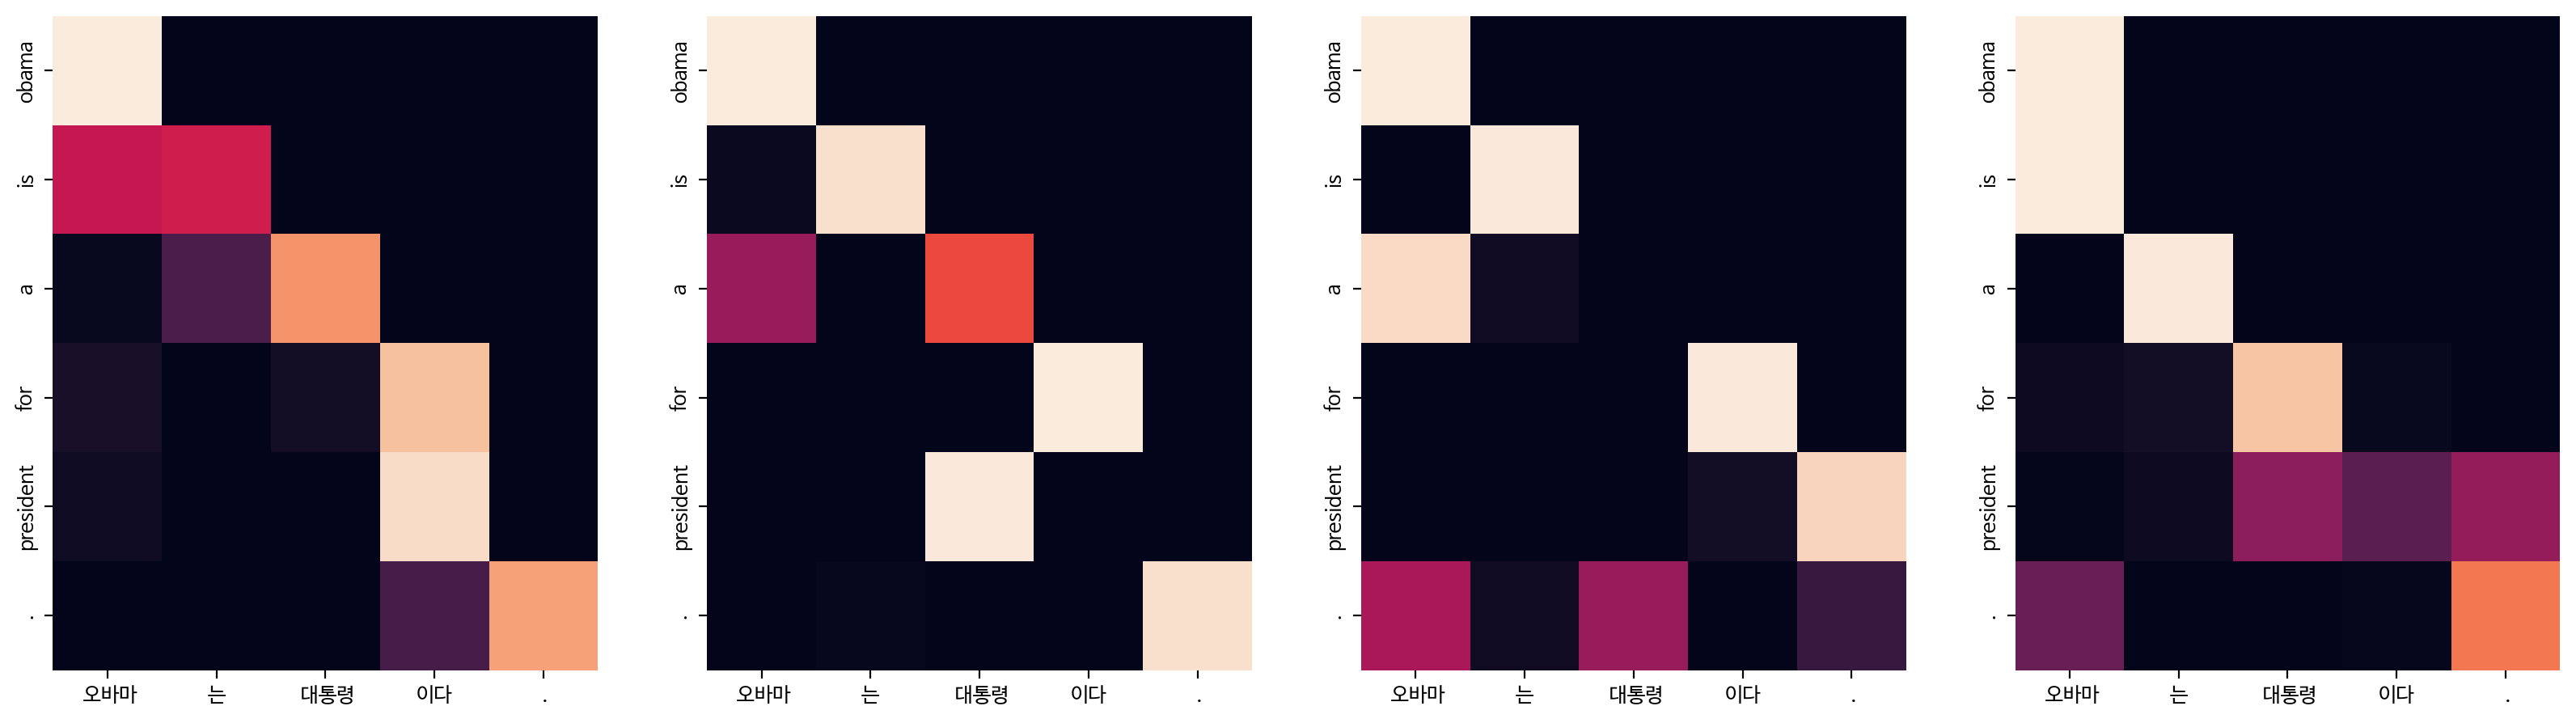

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/wor

Input: 시민들은 도시 속에 산다.
Predicted translation: they republican symbolsi make up packages of cities .
Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packa

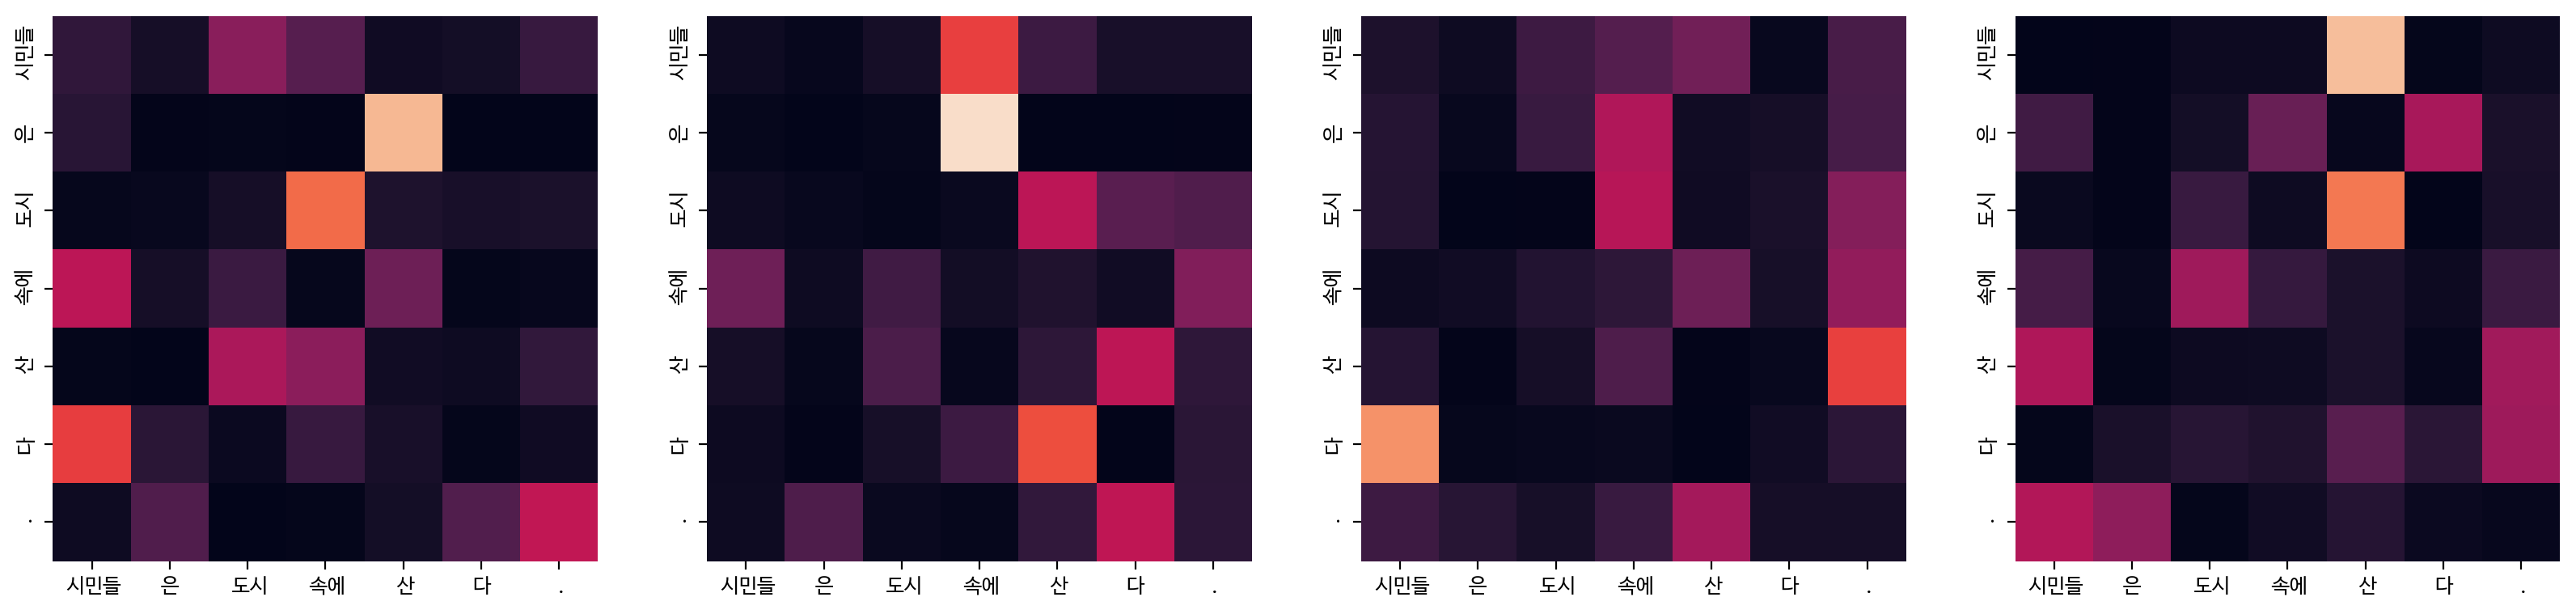

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/wor

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/pytho

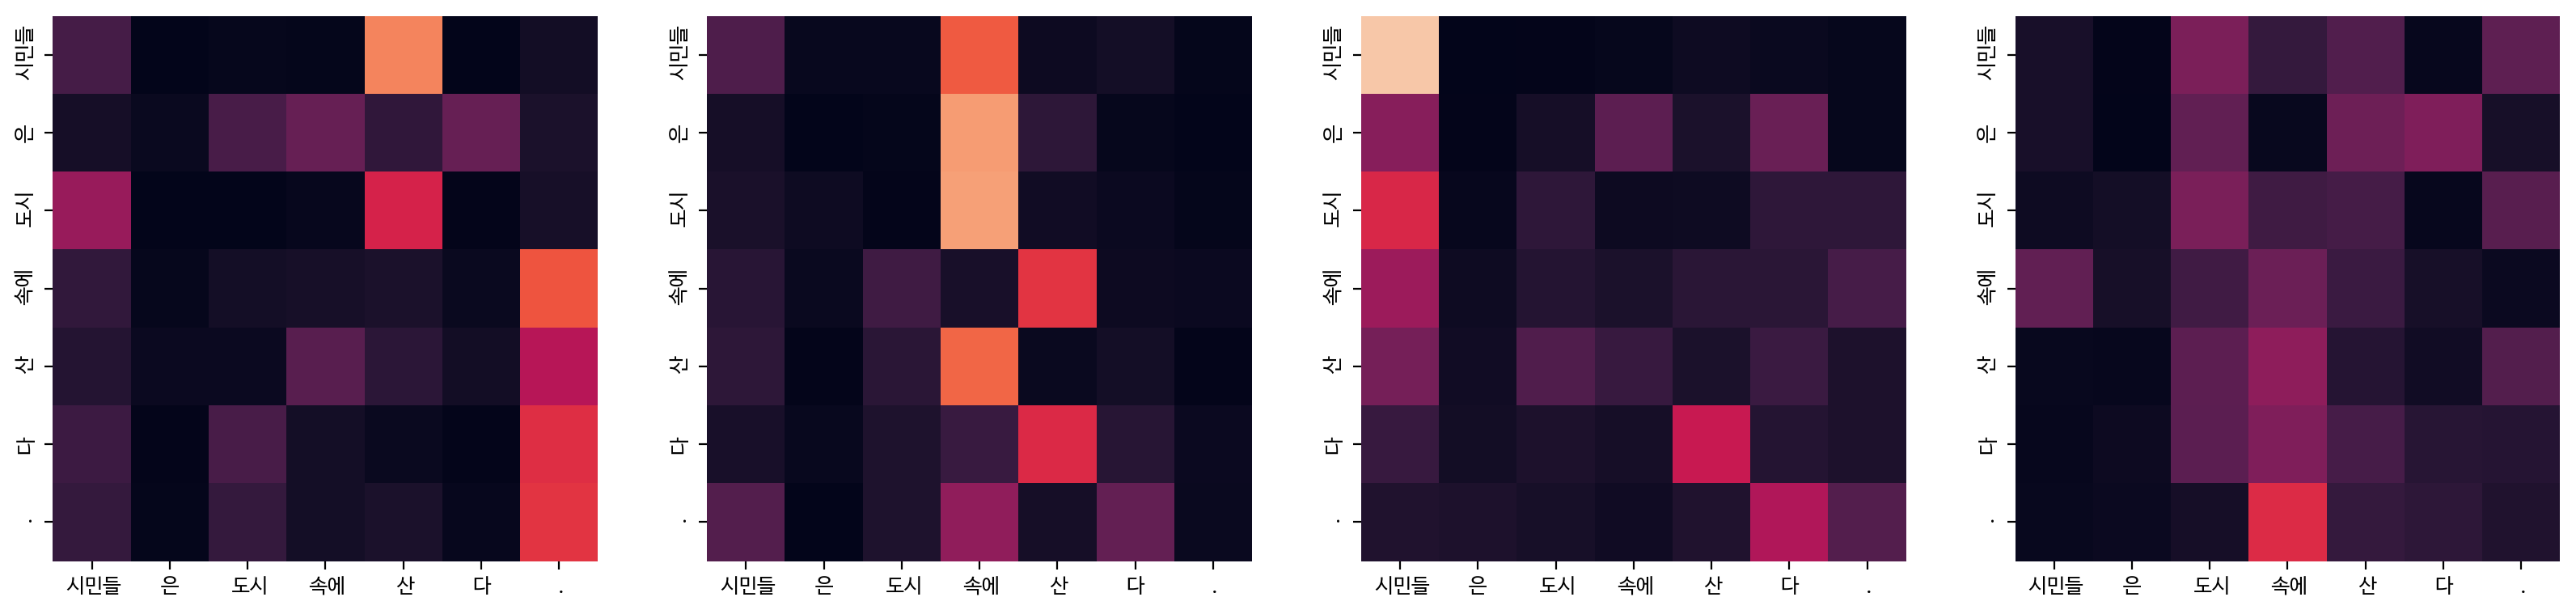

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

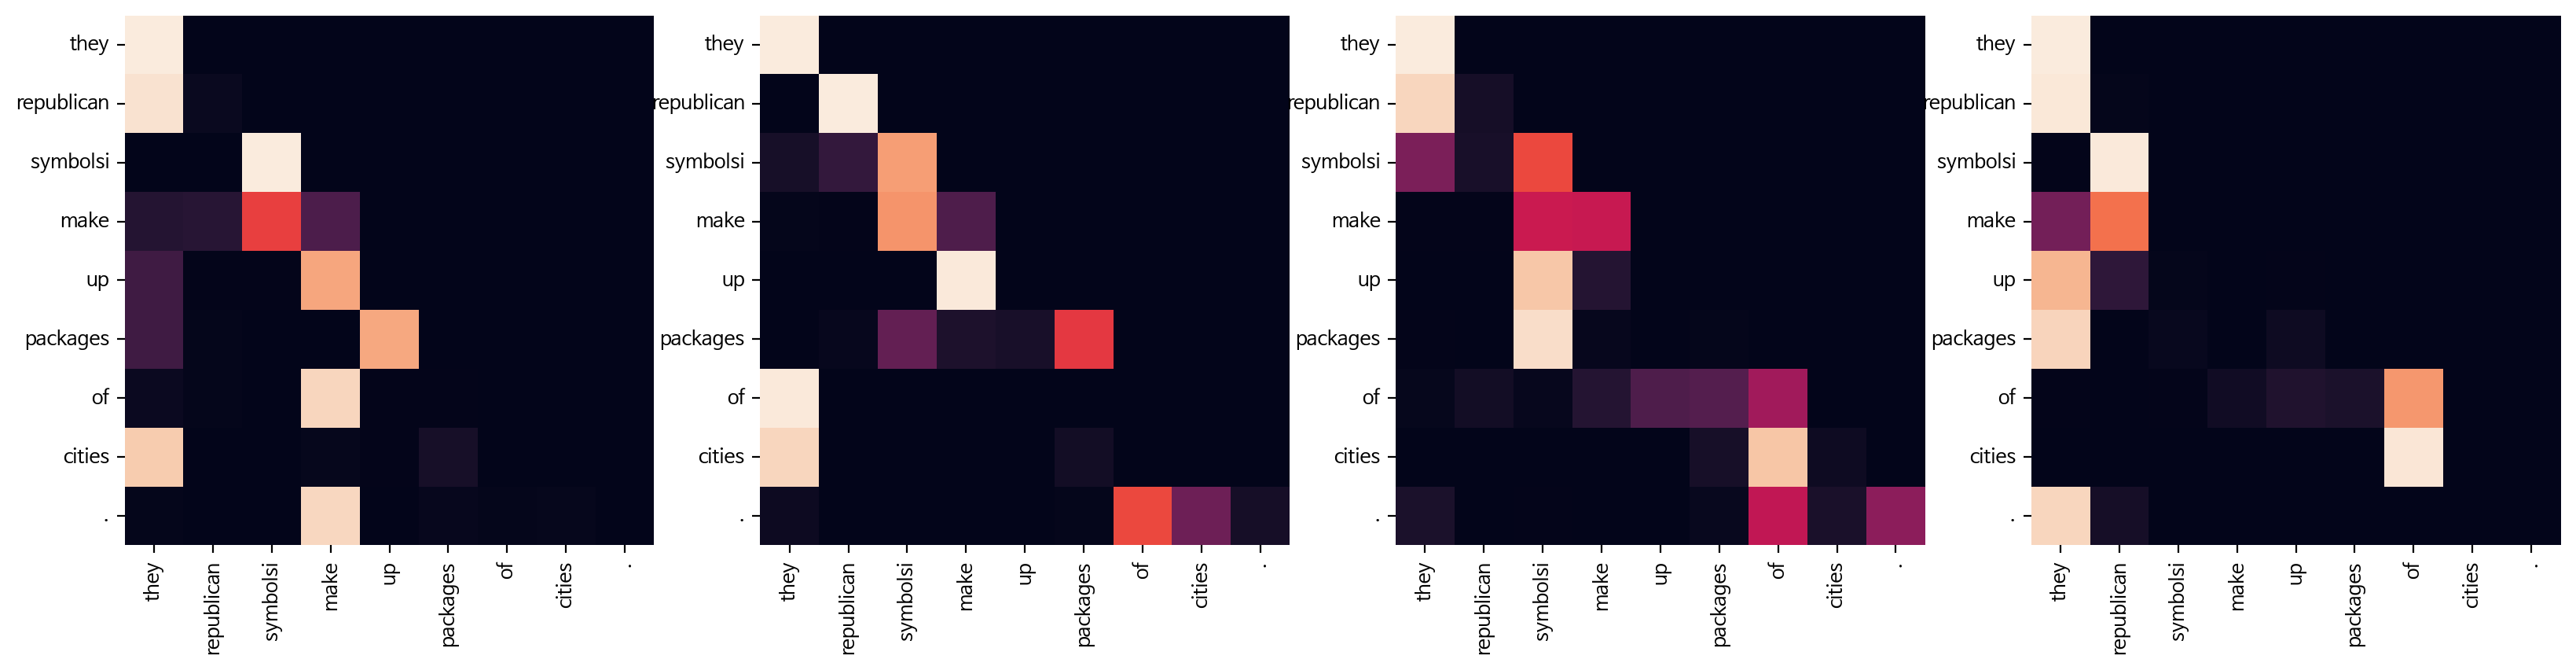

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/wor

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}

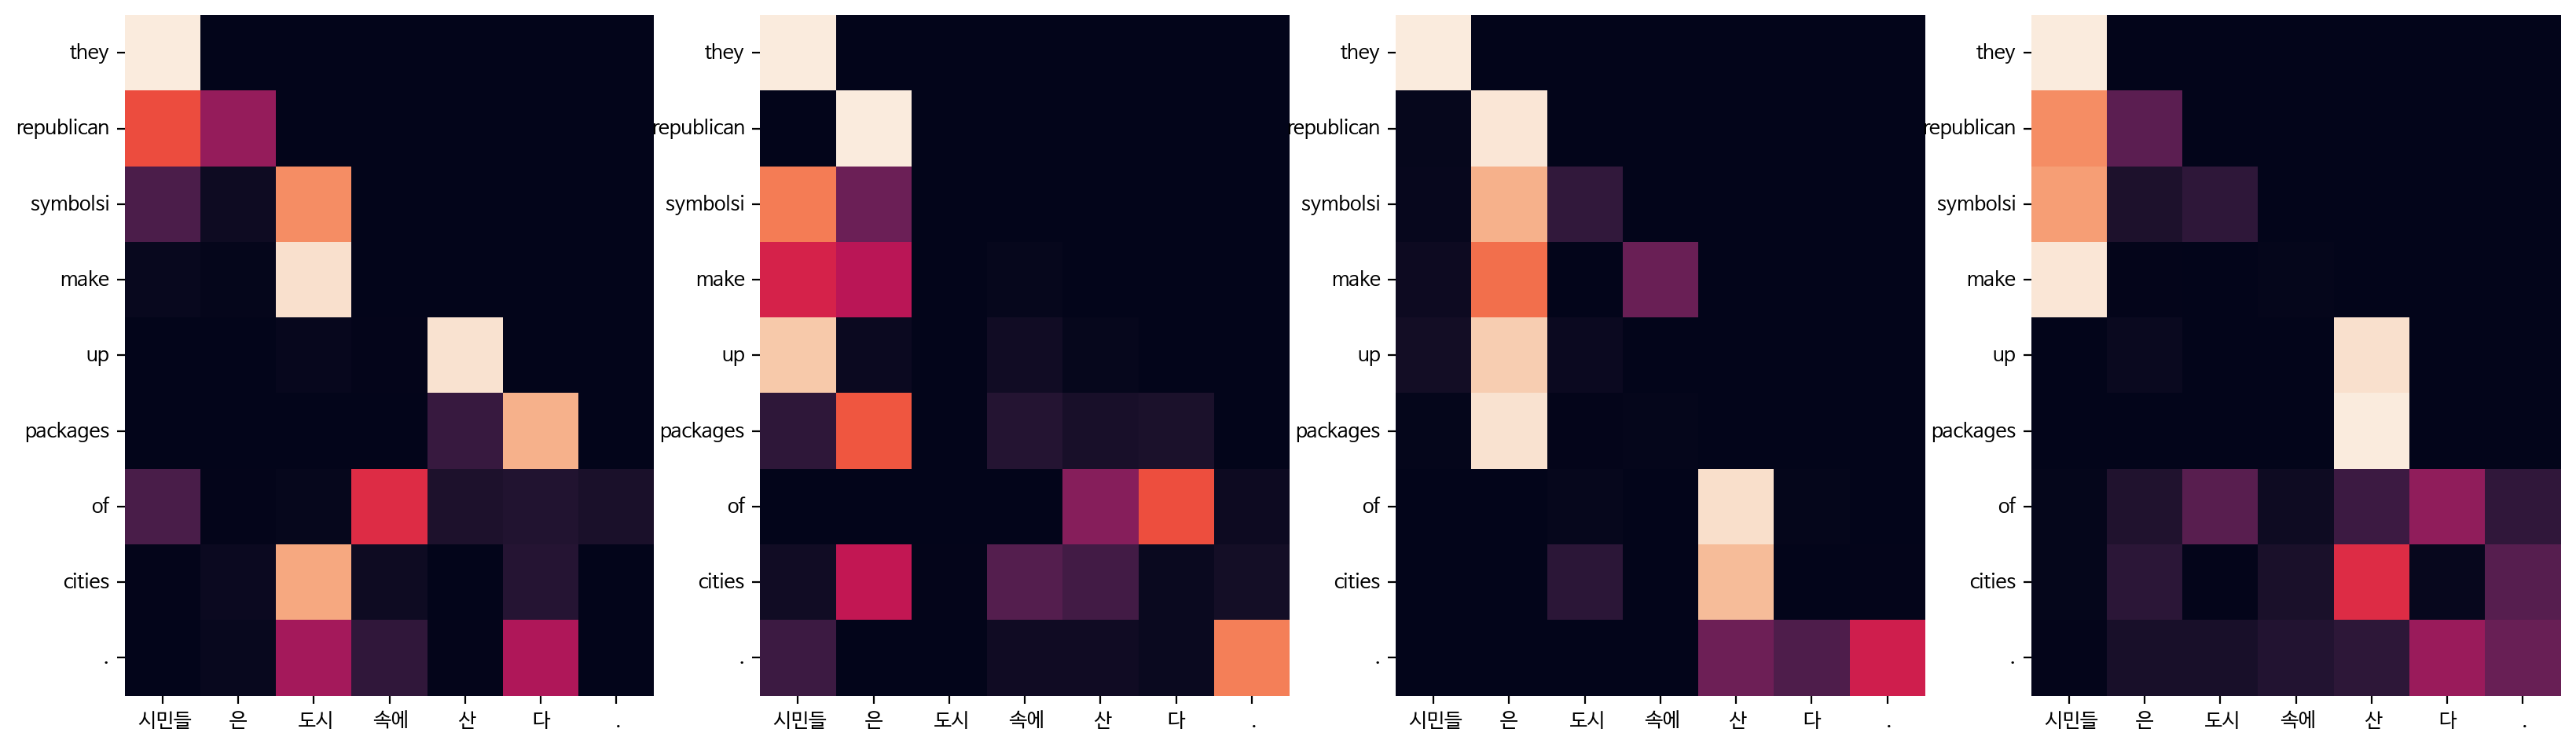

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

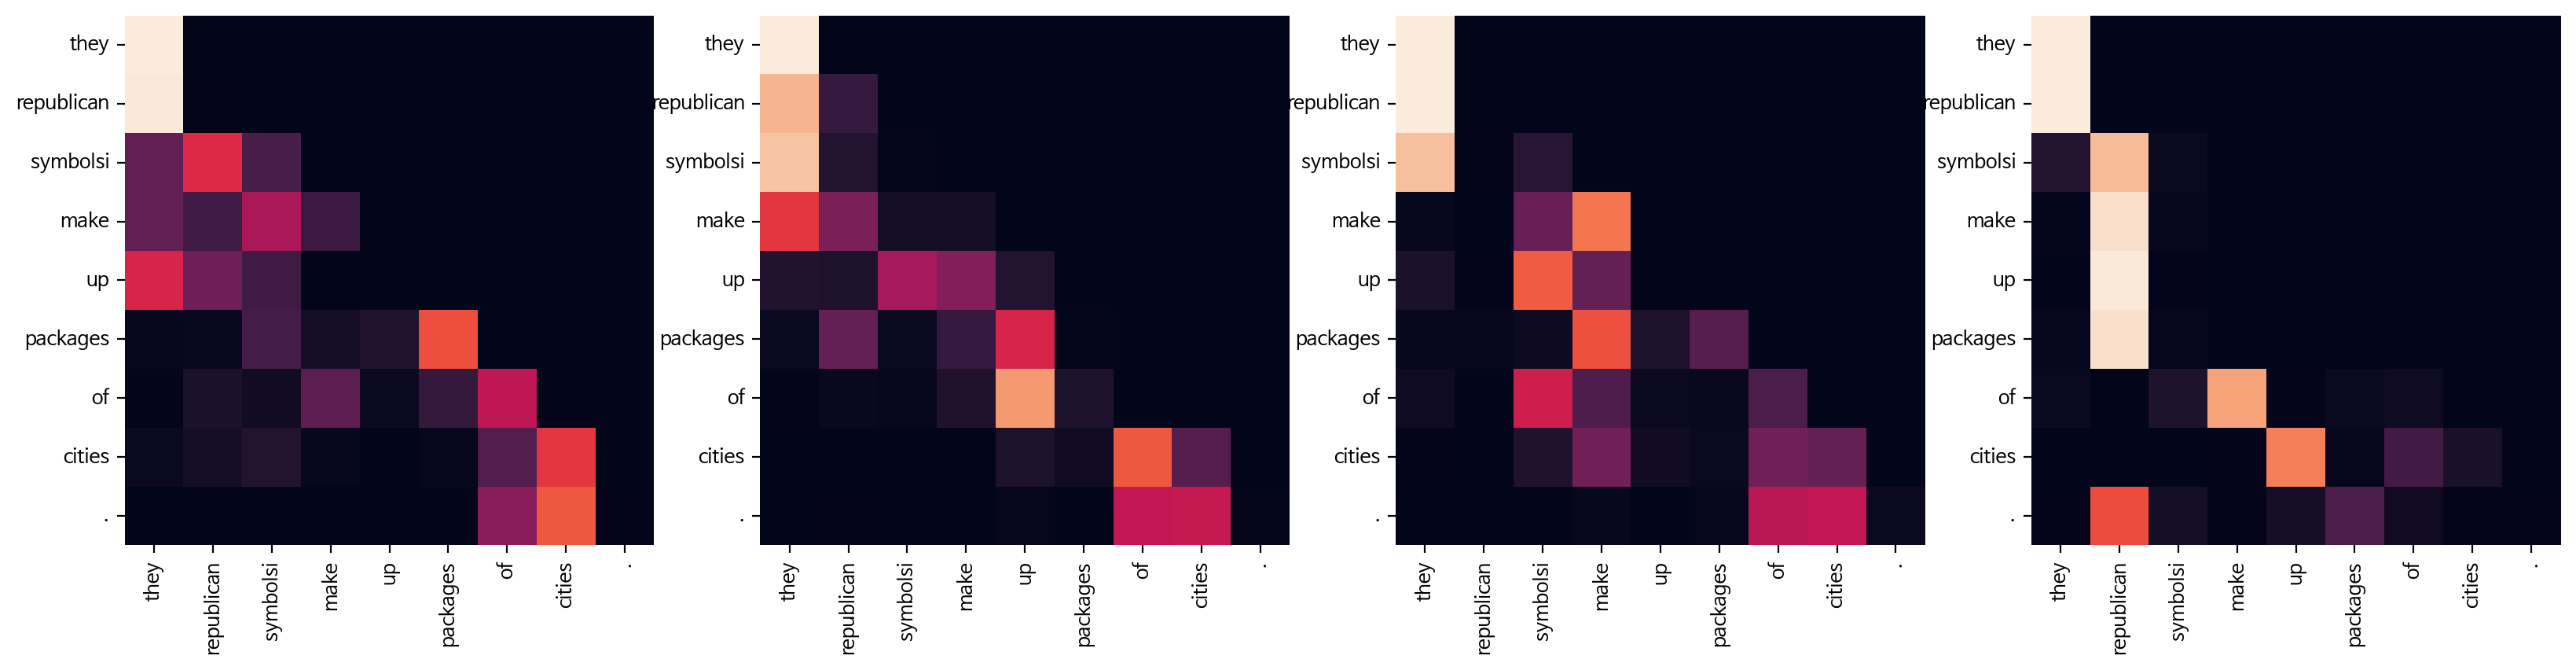

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 48124 (\N{HANGUL SYLLABLE MIN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/wor

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/sea

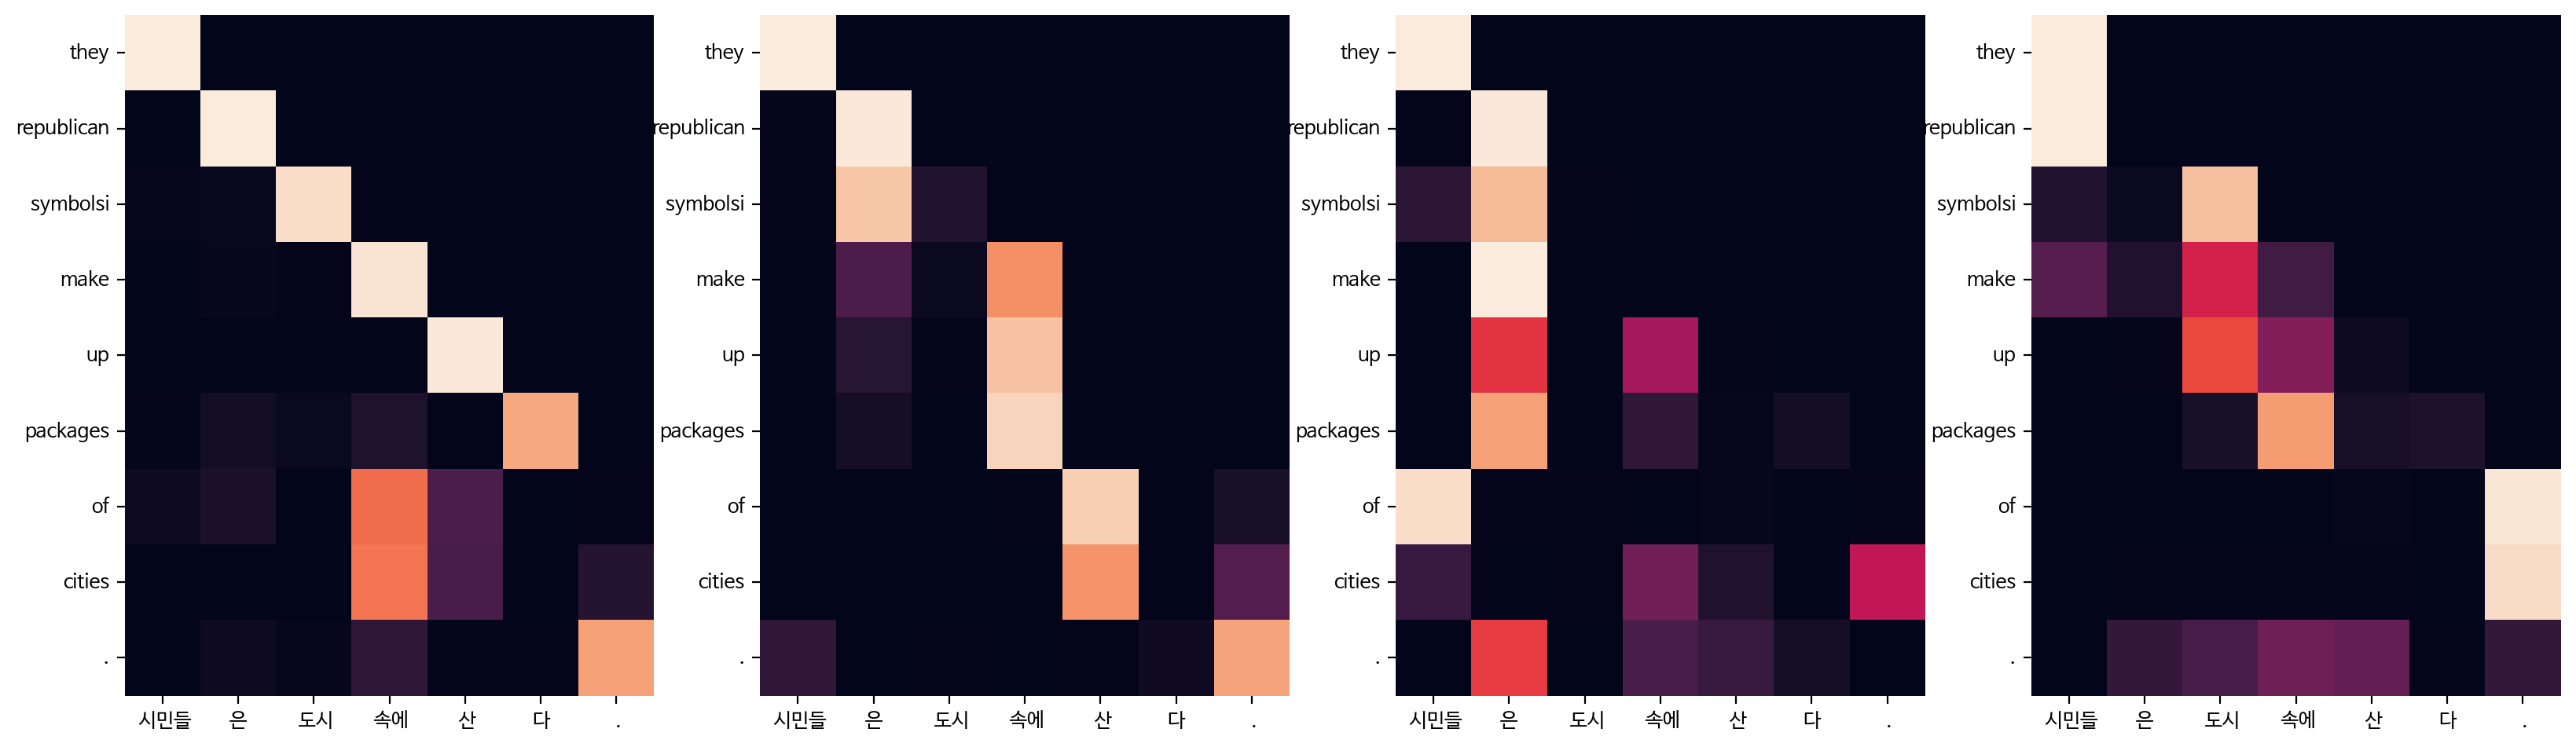

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/wor

Input: 커피는 필요 없다.
Predicted translation: there need for coffee
Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGU

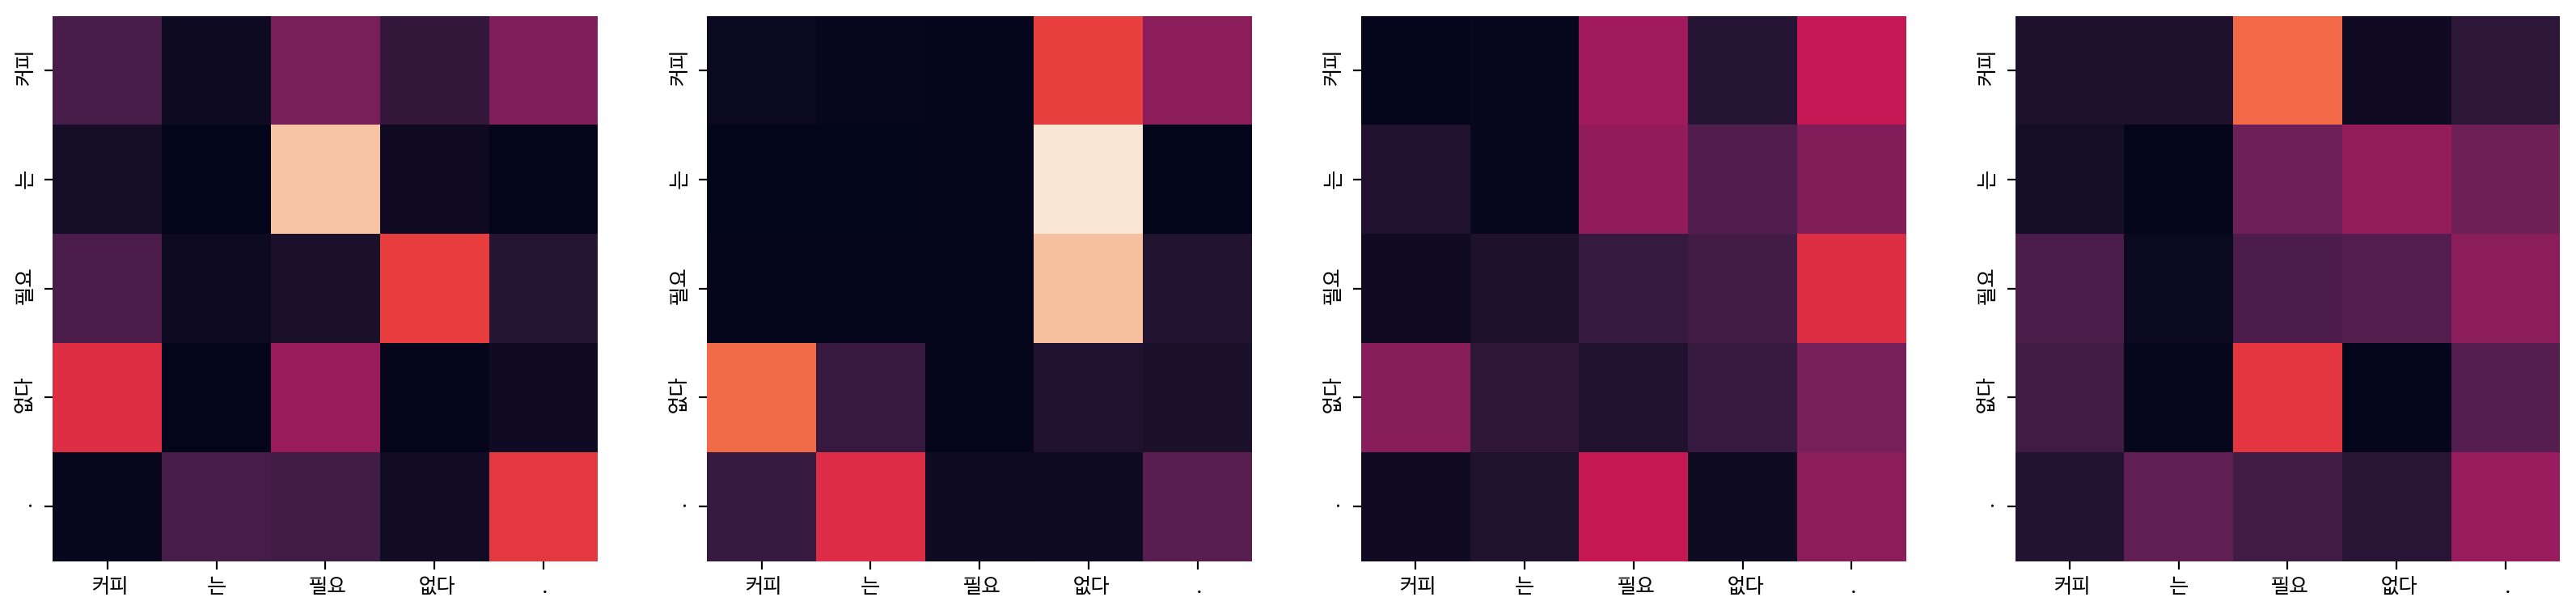

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/wor

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubu

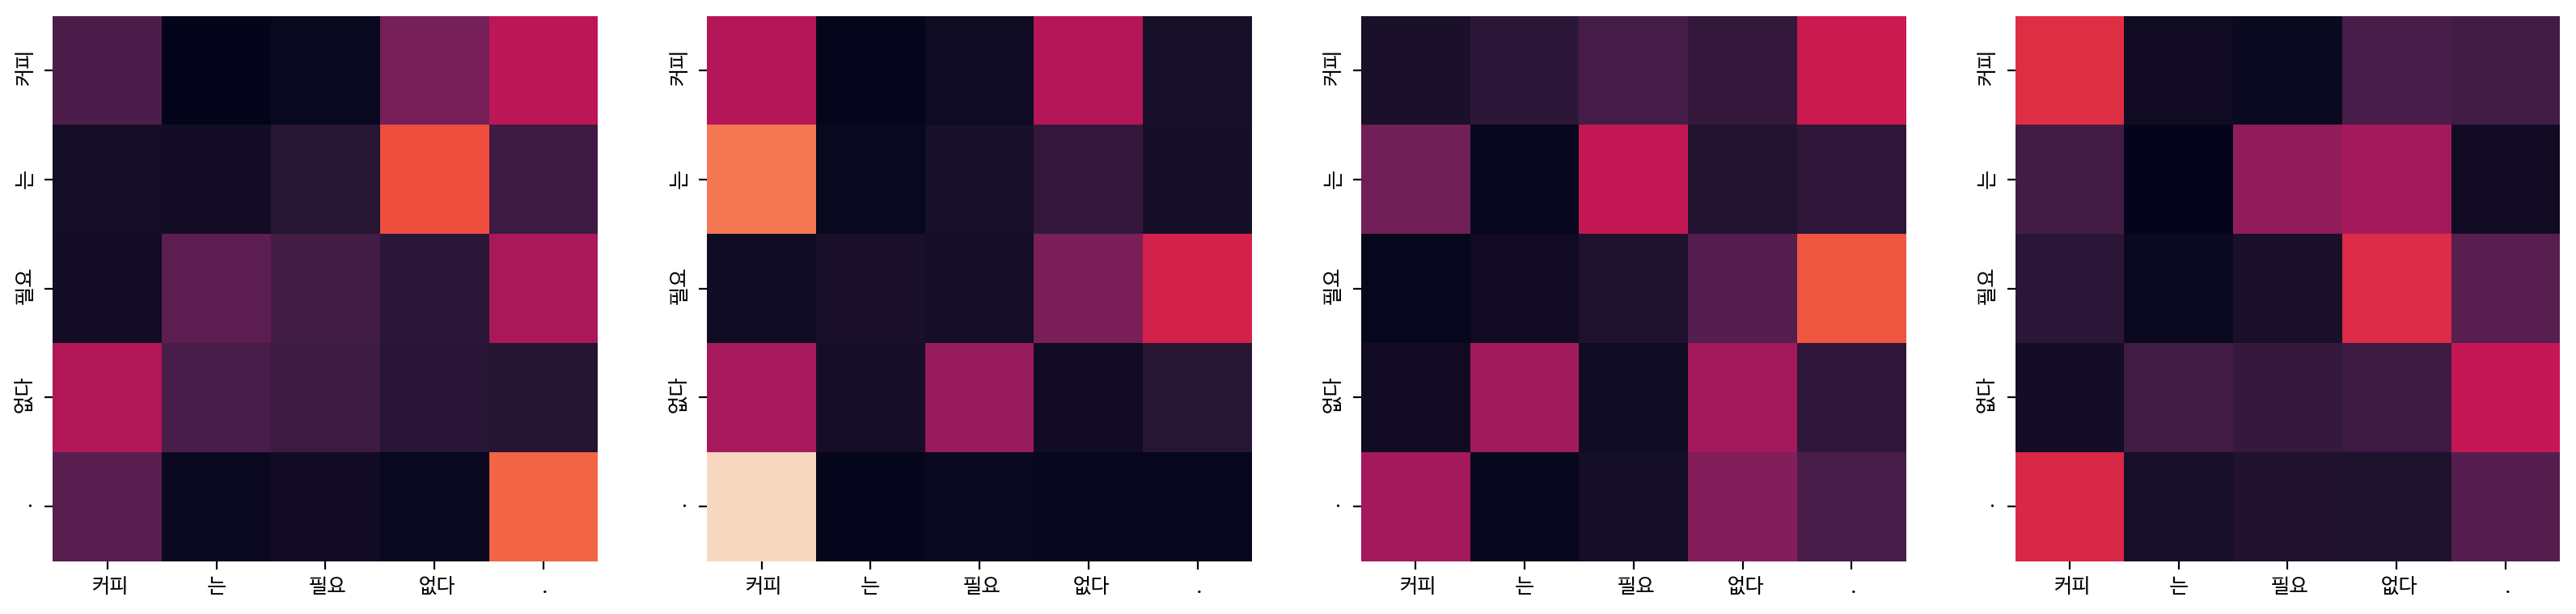

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

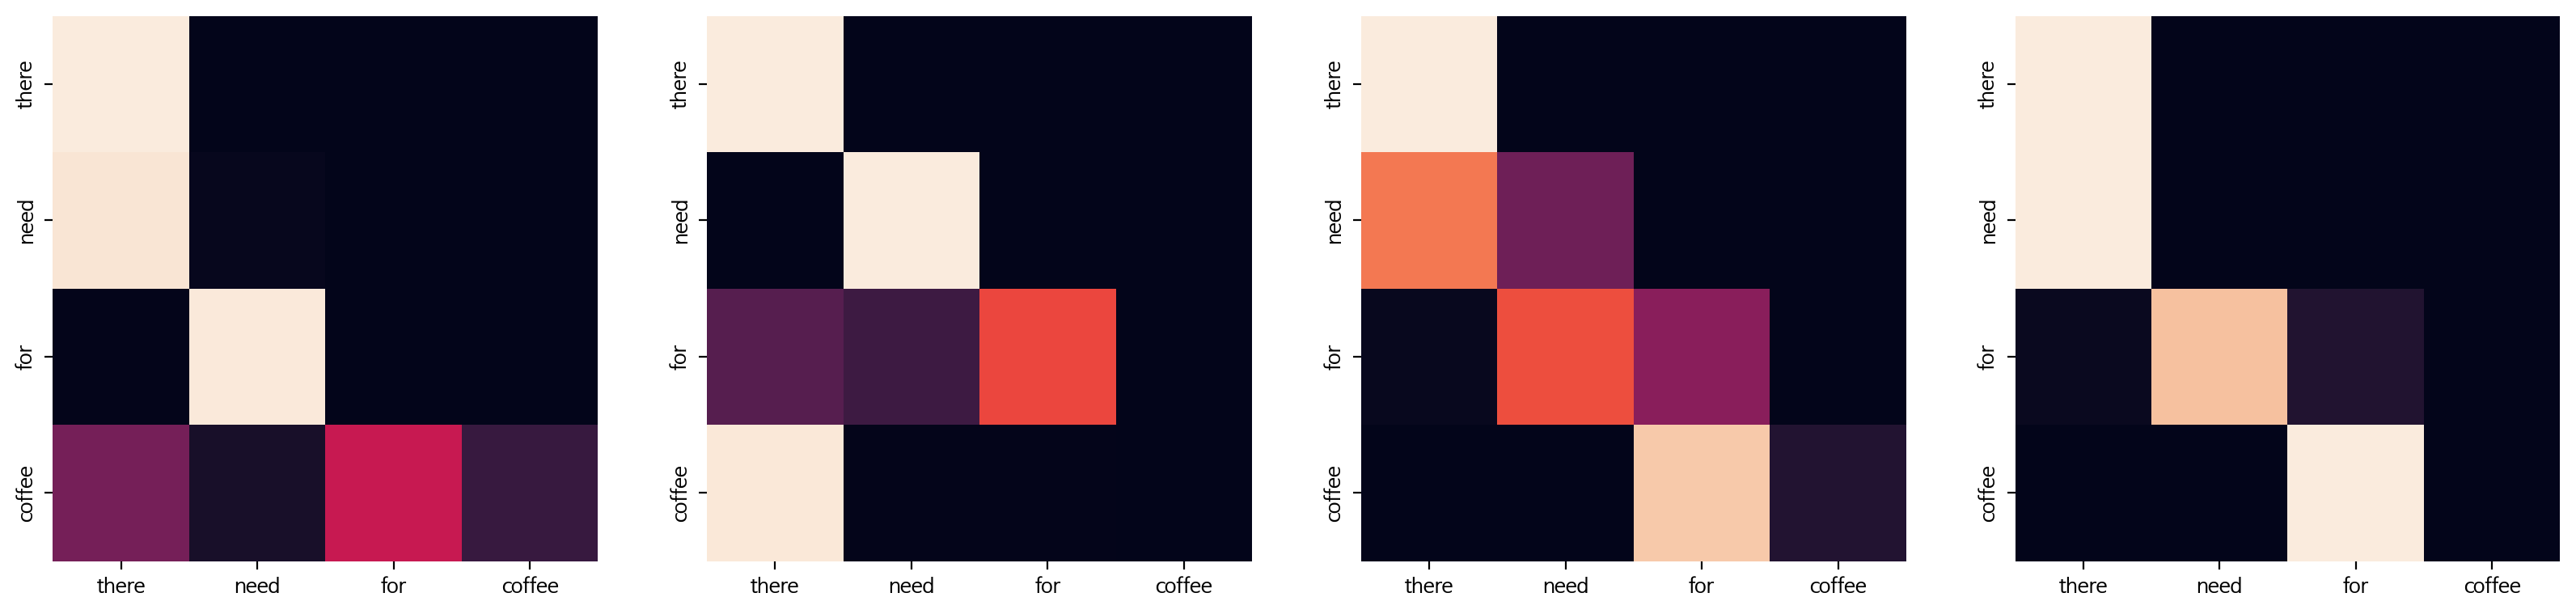

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/wor

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not fou

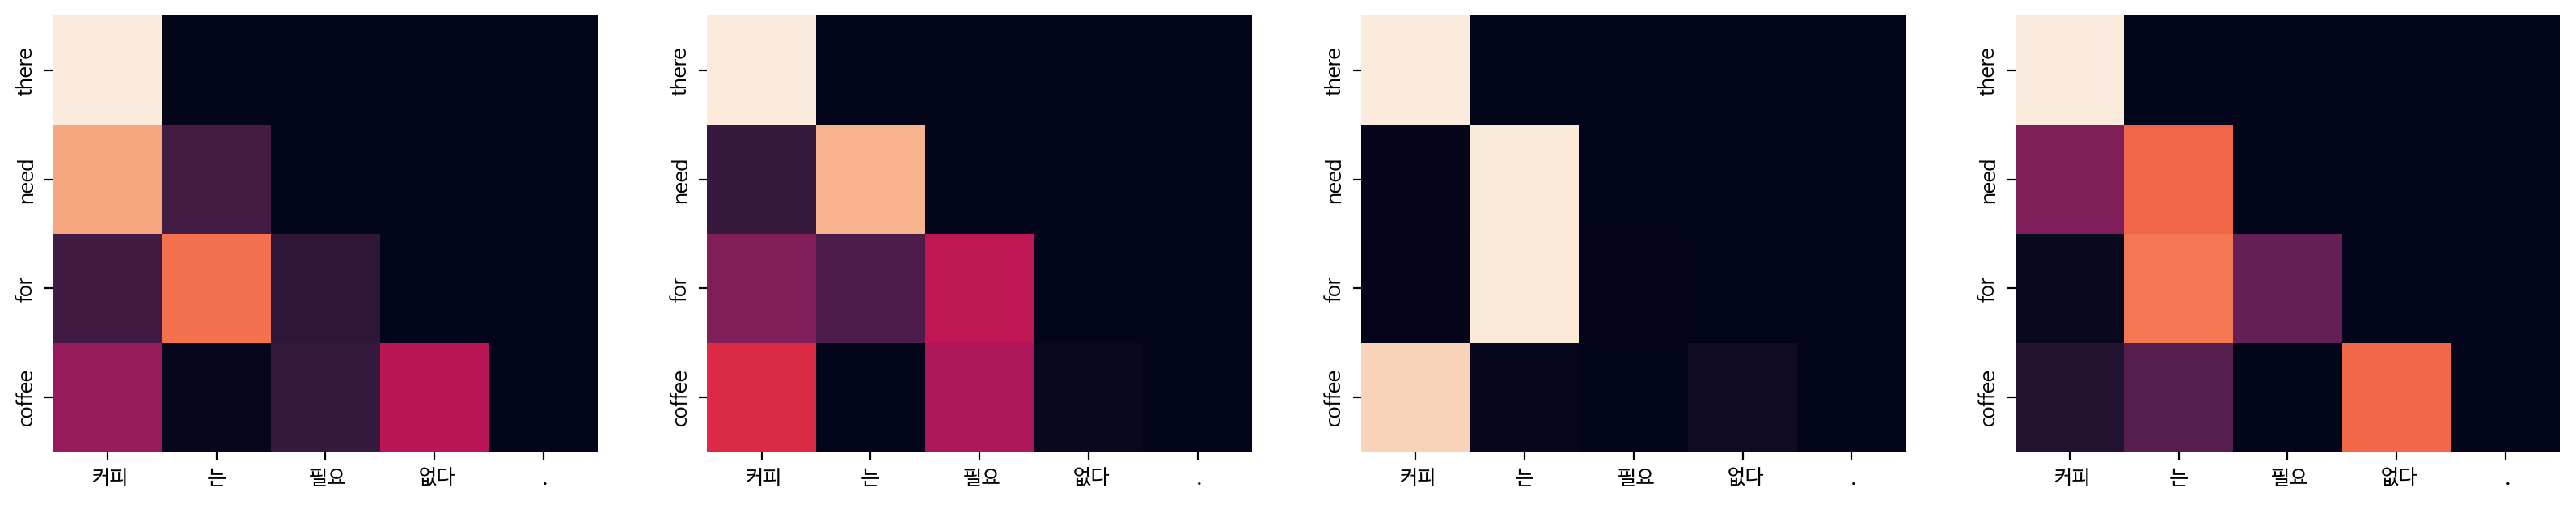

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

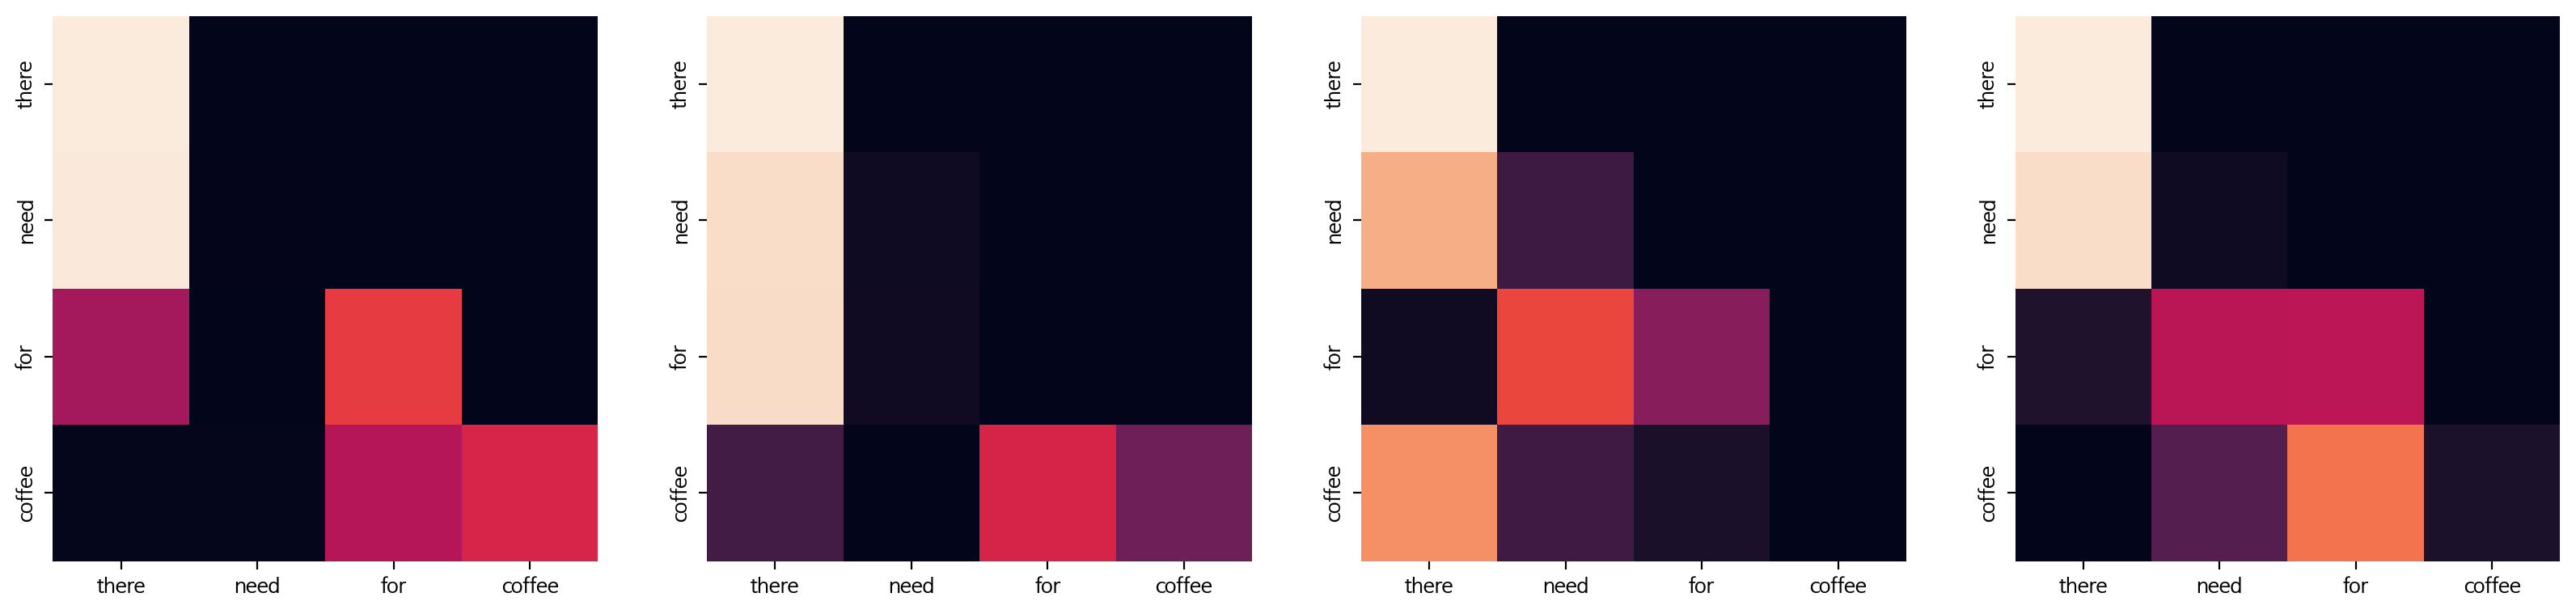

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54596 (\N{HANGUL SYLLABLE PIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/wor

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 54588 (\N{HANGUL SYLLABLE PI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 45716 (\N{HANGUL SYLLABLE NEUN}) missing fro

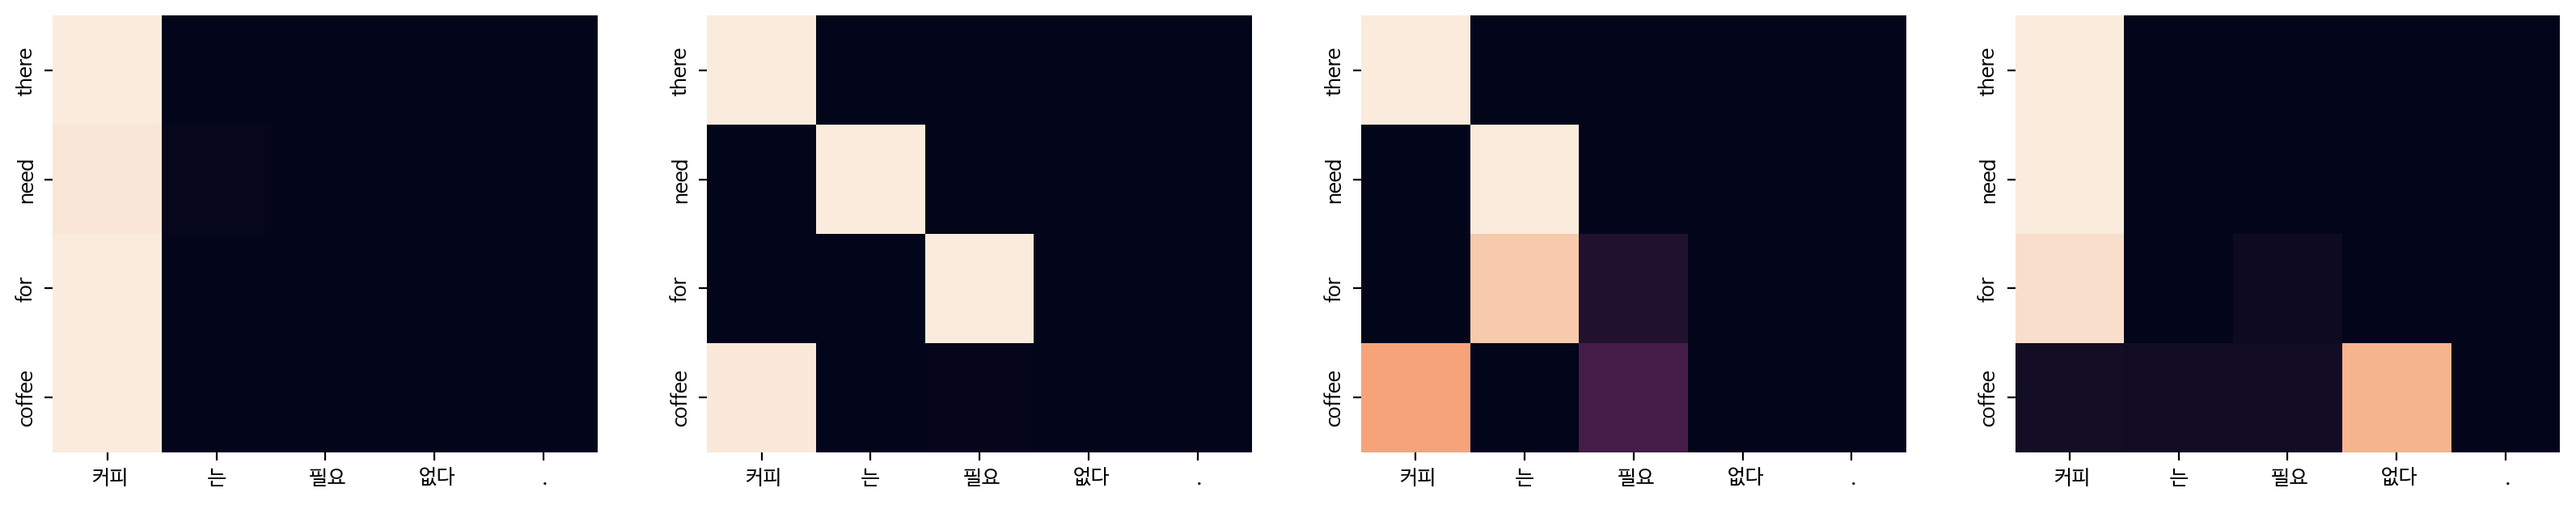

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font 

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed sunday .
Encoder Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_s

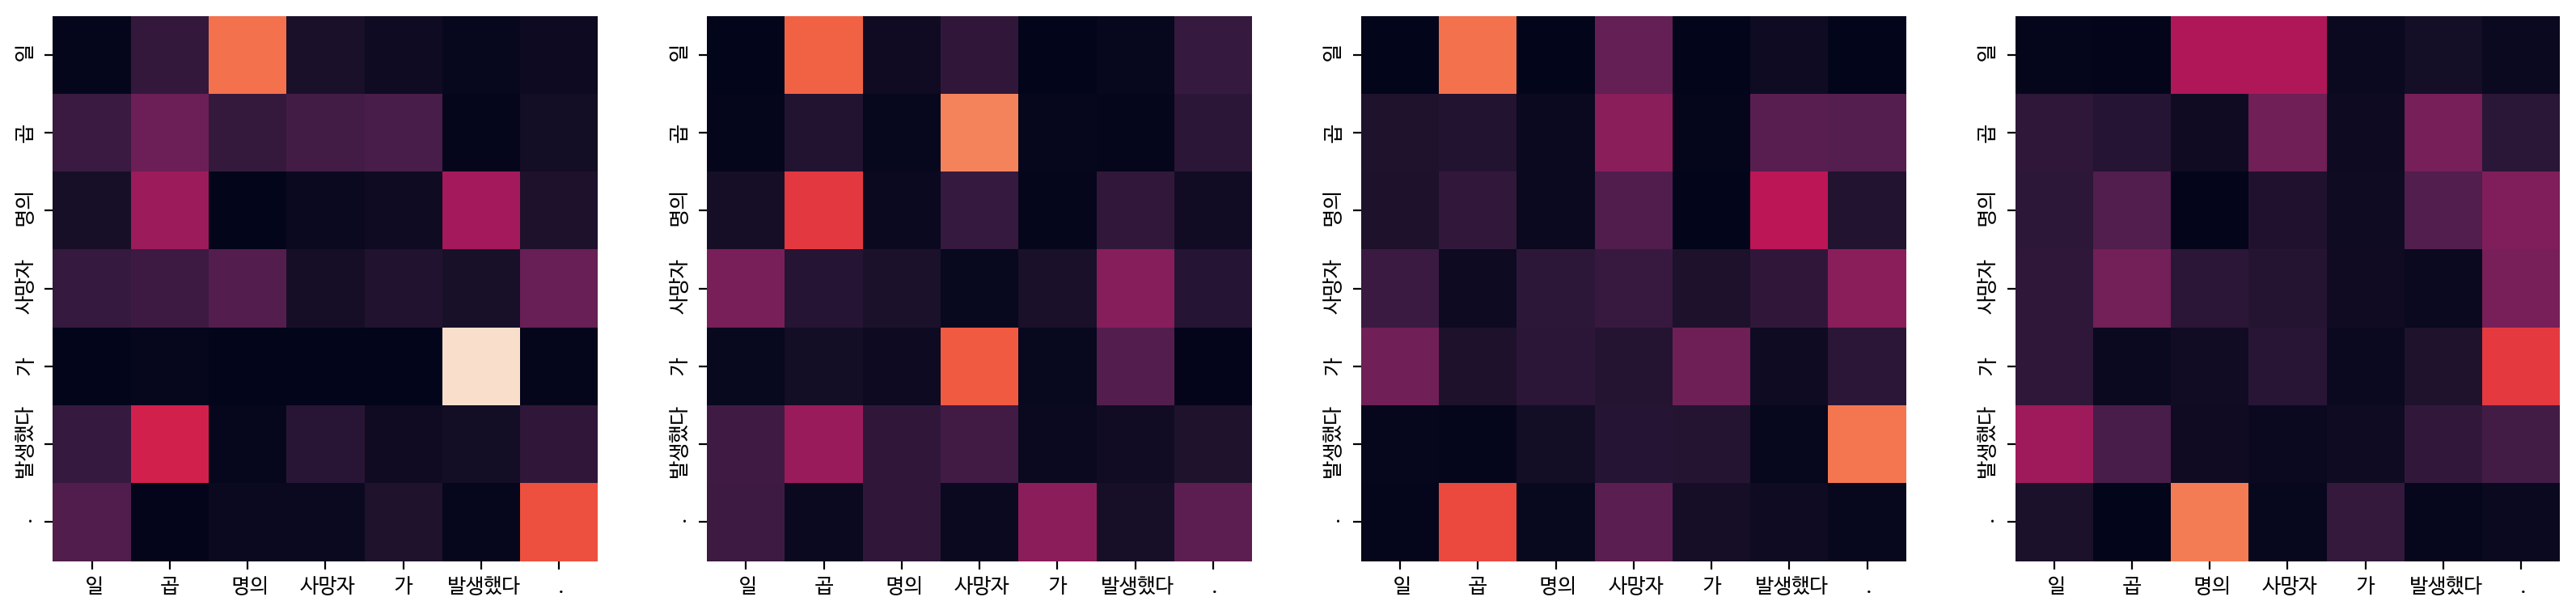

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font 

Encoder Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from font(s) DejaVu Sans.
  fig.canvas.dra

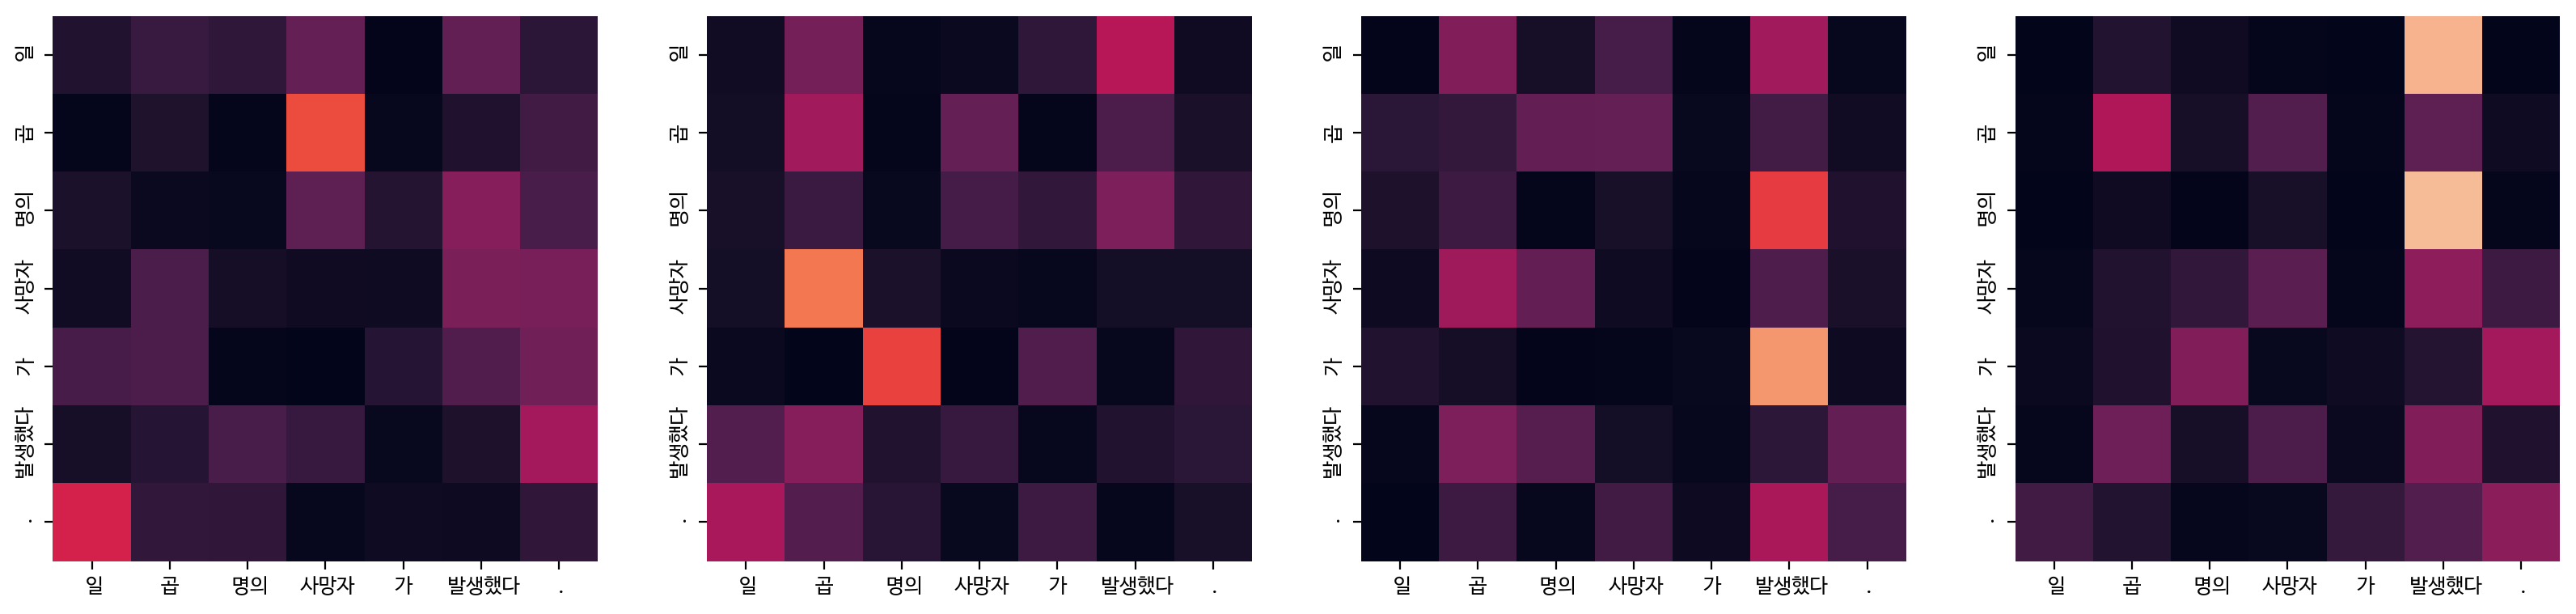

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

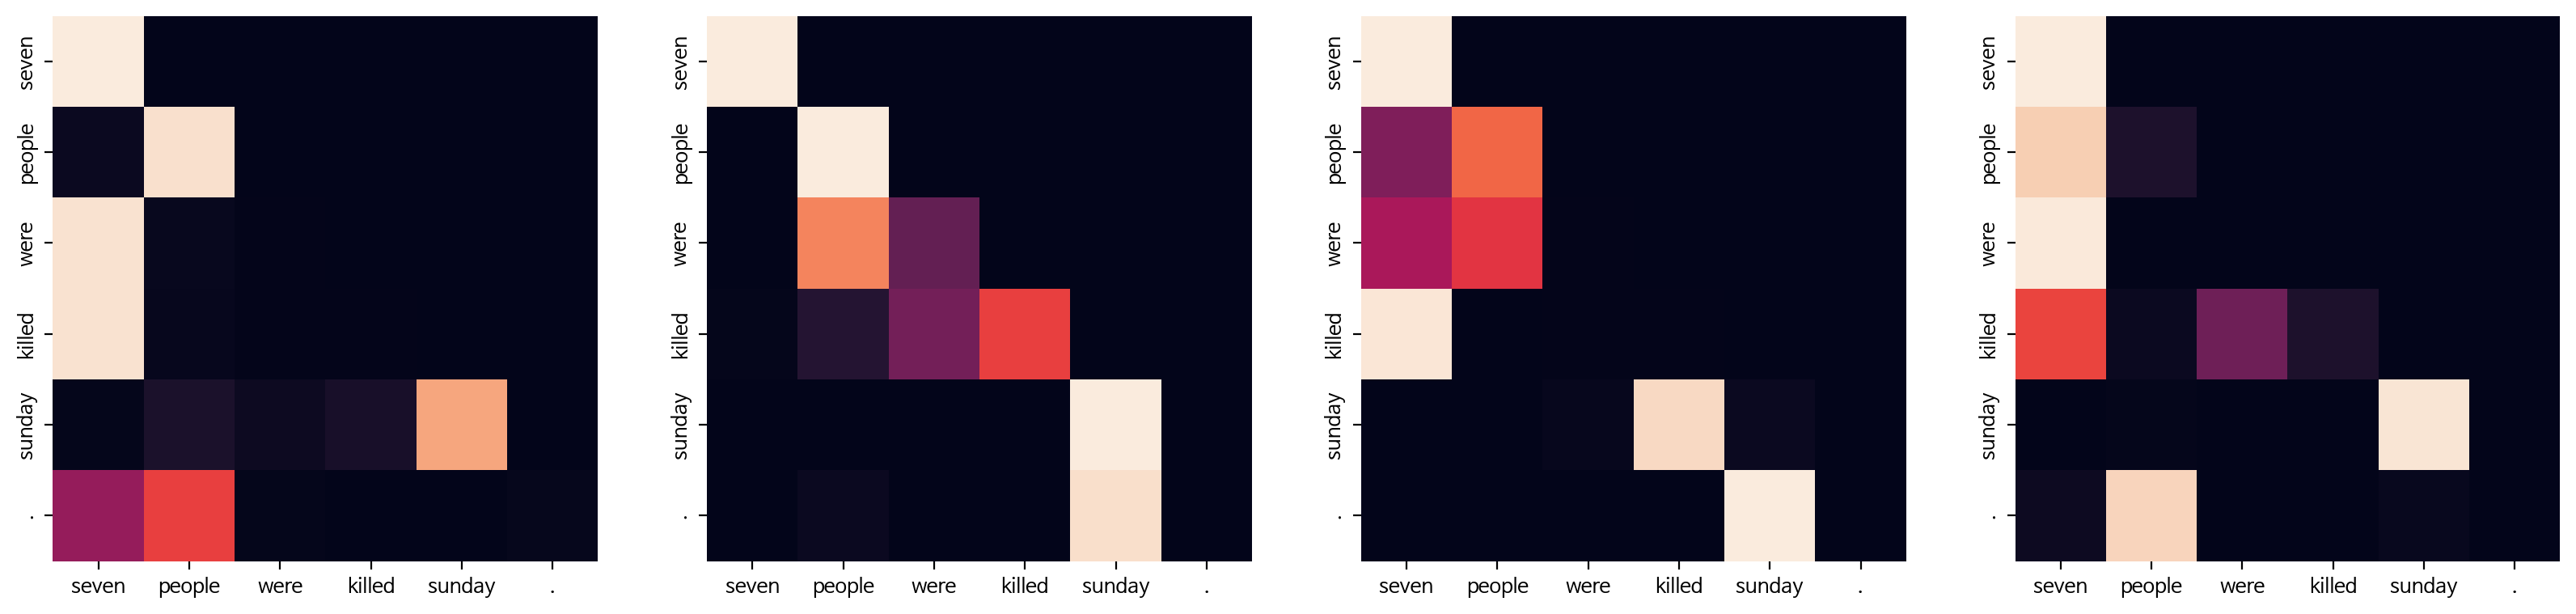

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font 

Decoder Src Layer 1


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.ai

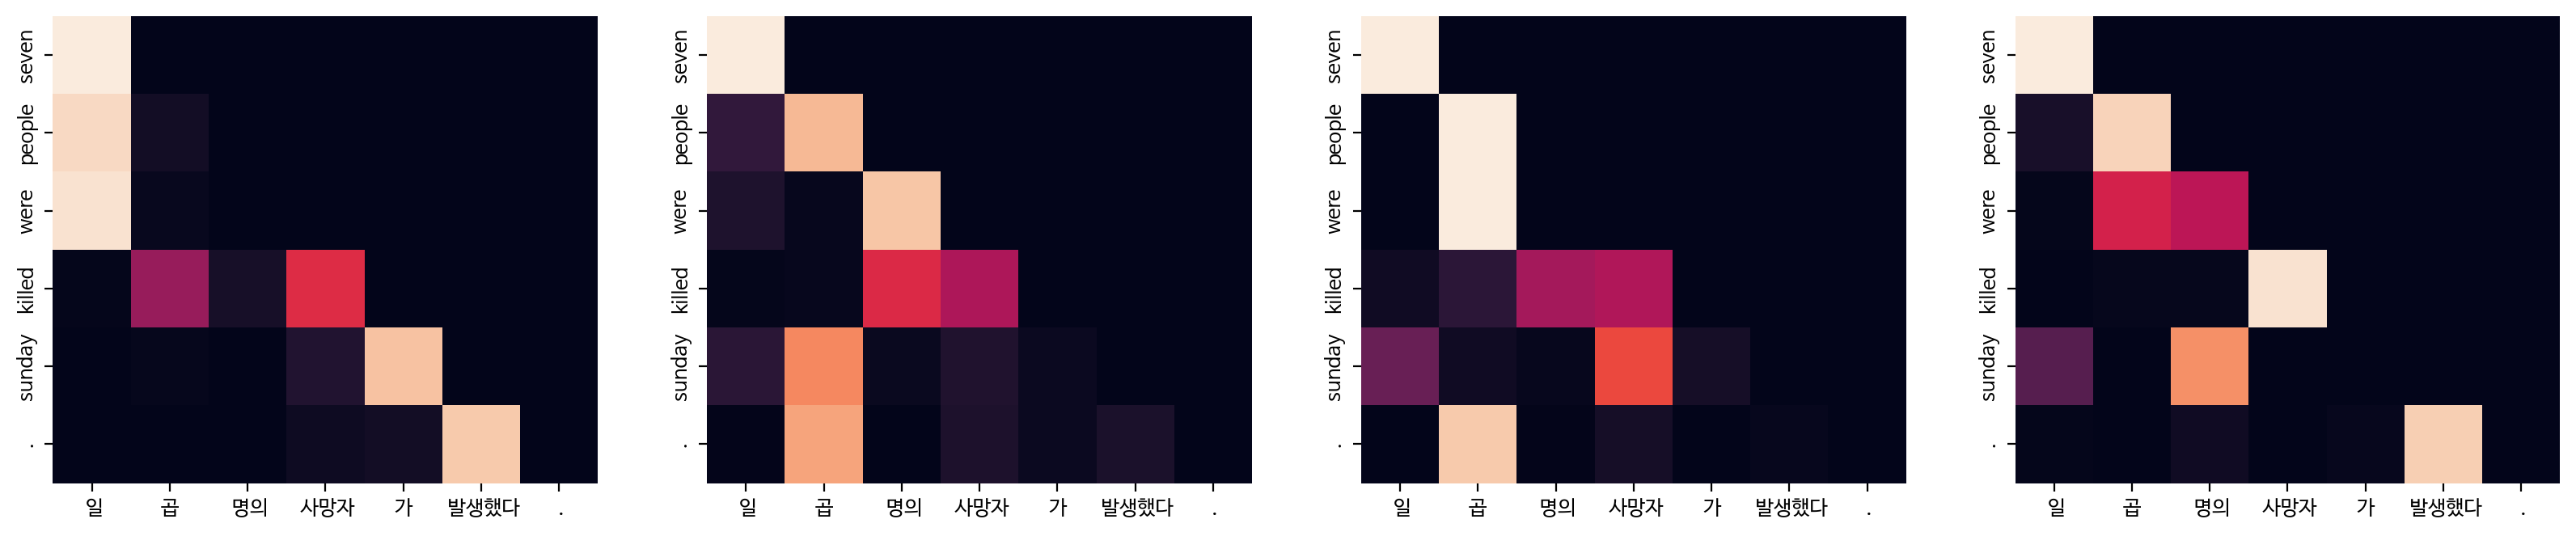

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

Decoder Self Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Fo

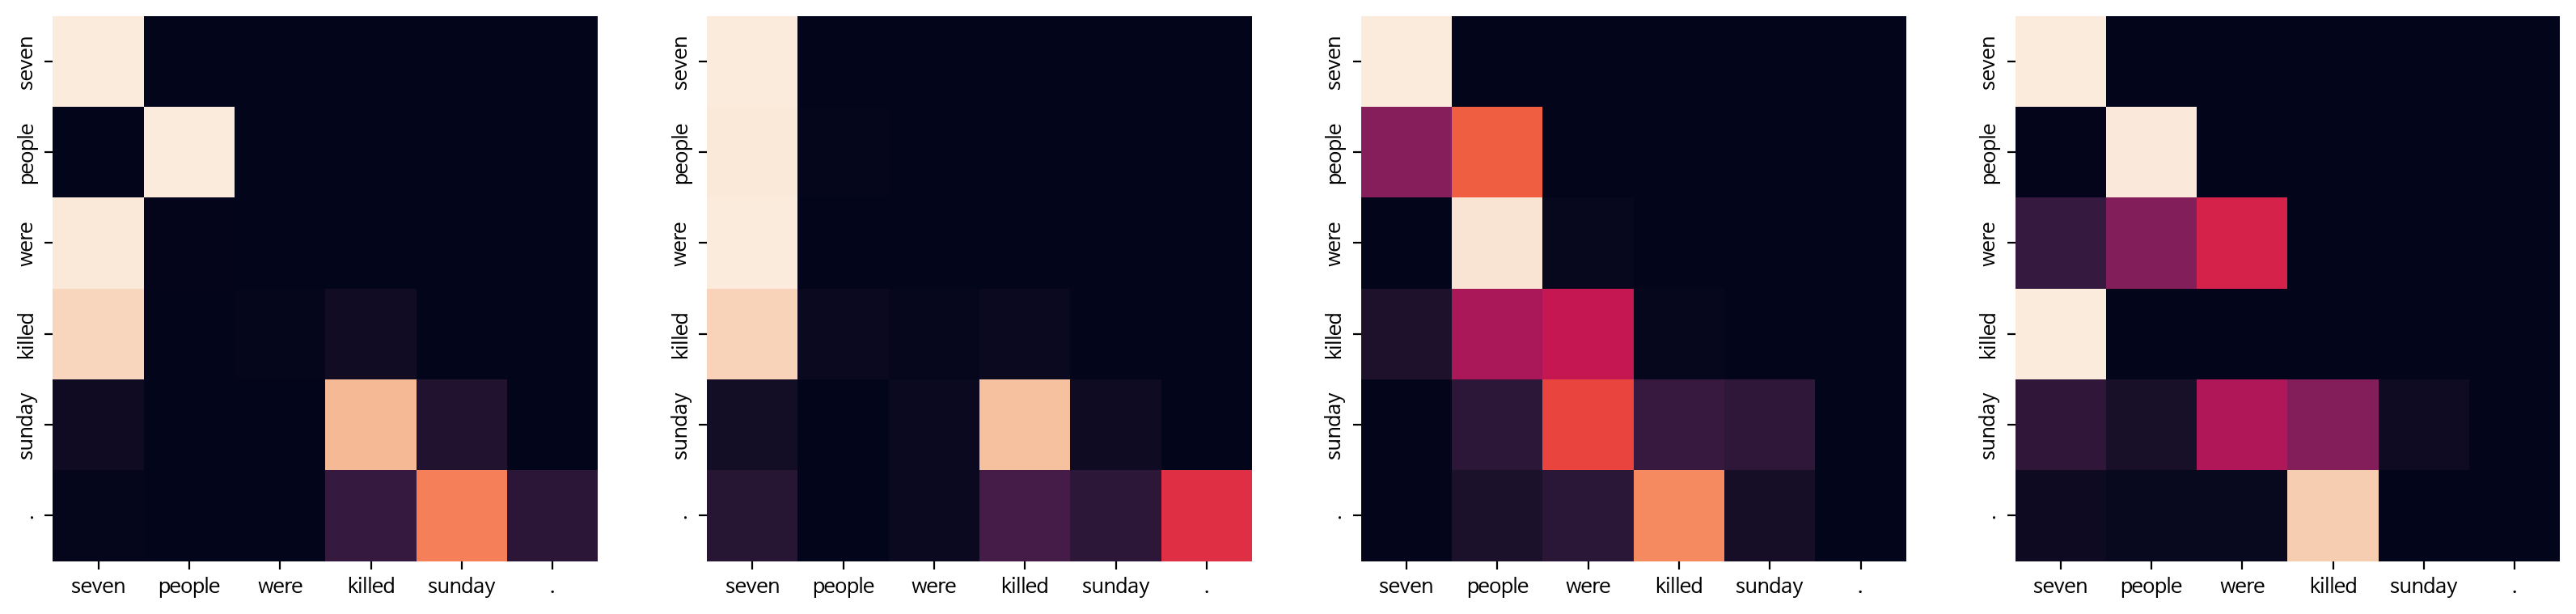

findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 44273 (\N{HANGUL SYLLABLE GOB}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
findfont: Font 

Decoder Src Layer 2


findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from font(s) NanumBarunGothic.
  fig.canvas.draw()
findfont: Font family 'NanumBarunGothic' not found.
/home/ubuntu/work_space/aiffel/.aiffel/lib/python3.10/site-packages/seaborn/utils.py:61: UserWarning: Glyph 51068 (\N{HANGU

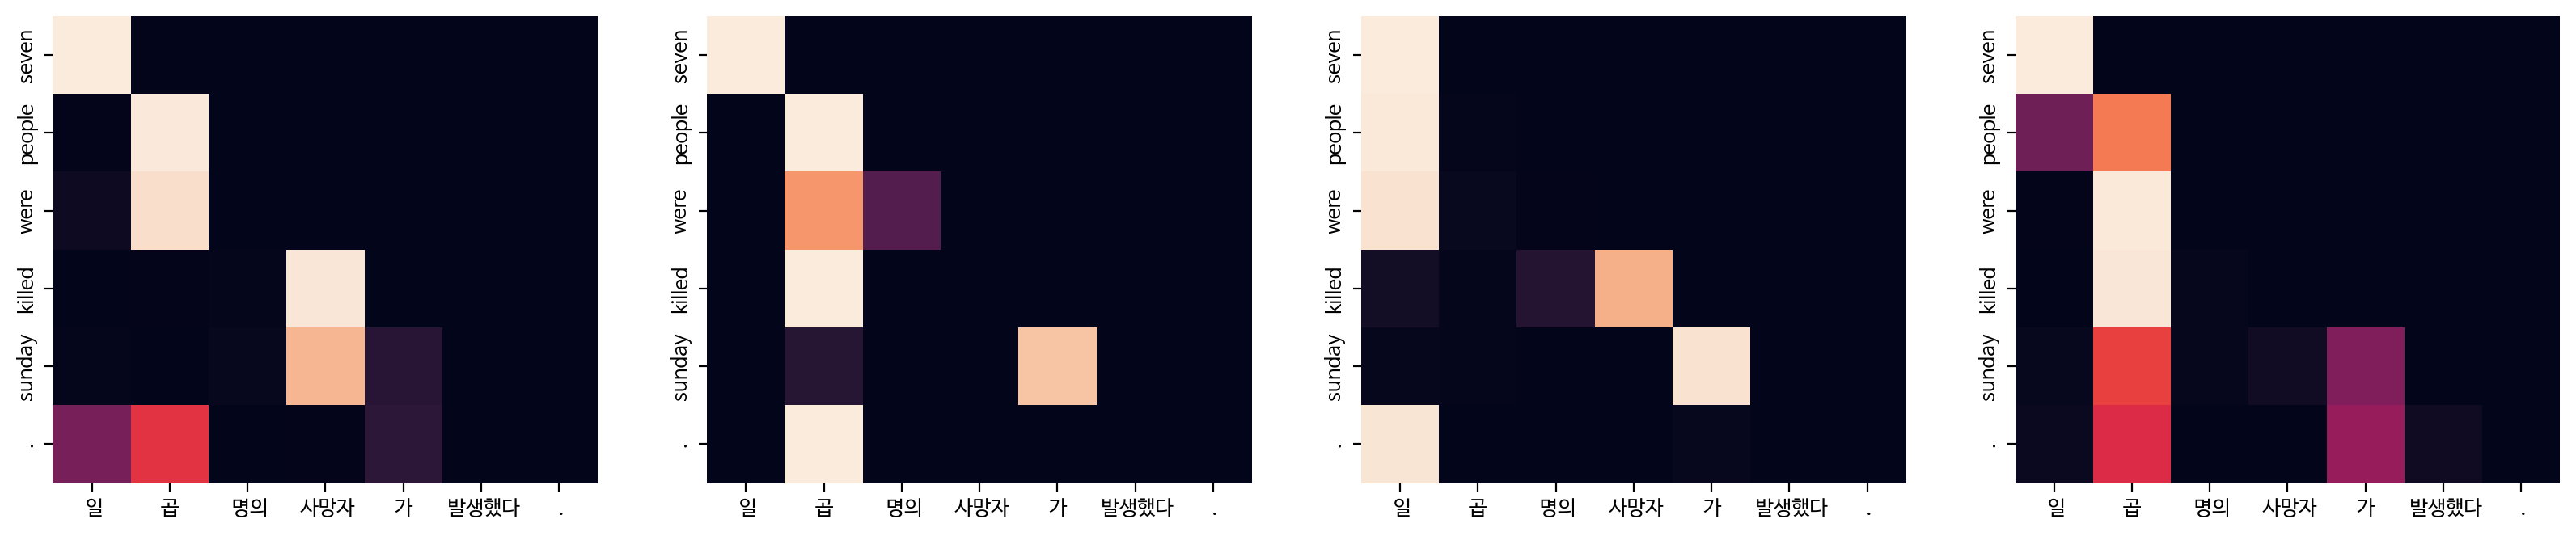

In [33]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, True)